In [1]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv

#Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

# BPM Data

In [2]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 166])
Pos_ybpms = np.zeros([1024, 165])
S_xbpms = np.zeros([1024, 166])
S_ybpms = np.zeros([1024, 165])
with open('Hacd_baseline_0.05v_0.008_01.dat') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%166
            
            if (i - init_i)%166 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 169375:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%165
            
            if (i - init_i)%165 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(166, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(165, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.16726721195157668


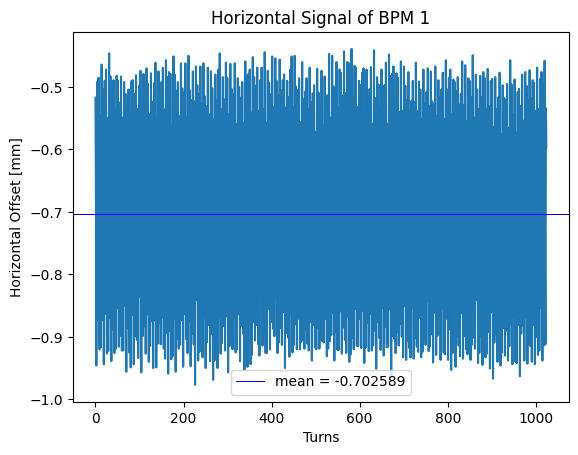

Standard deviation of First Vertical BPM = 0.02312735983286733


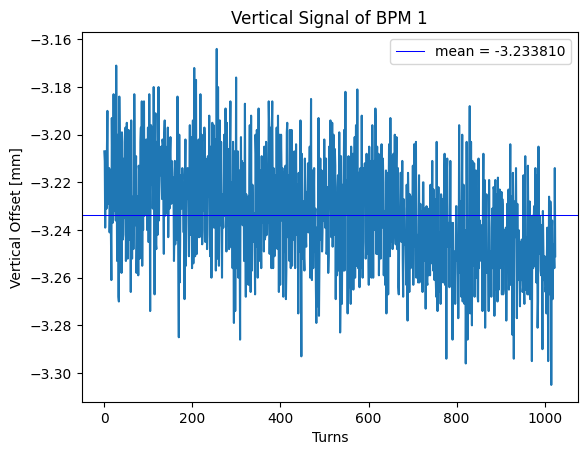

In [4]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

NAFFlib: 0.2945001983661274
Scipy: 0.29452054794520544


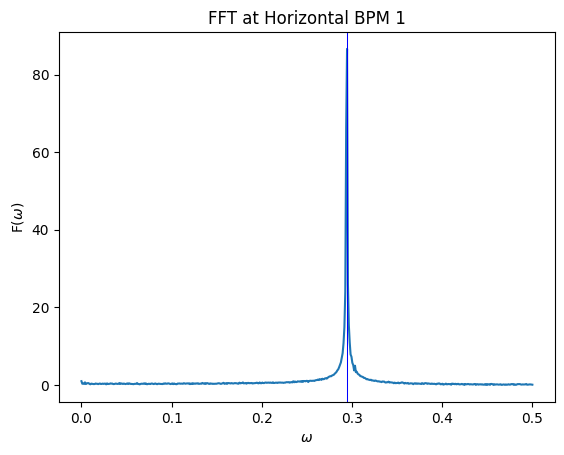

0.29452054794520544


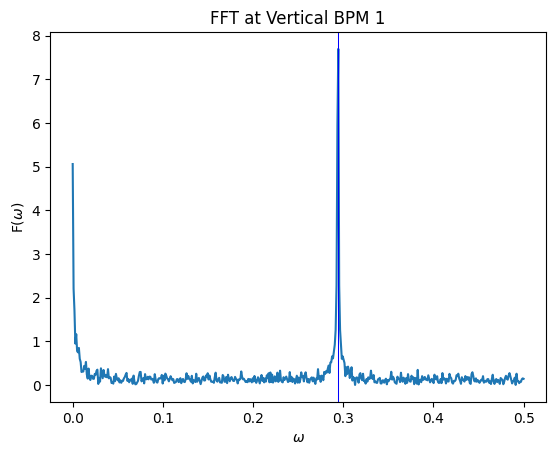

In [8]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print("NAFFlib:", naf.get_tune(BPMx0))
print("Scipy:", BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.059518799945207035 0.0655176145452051


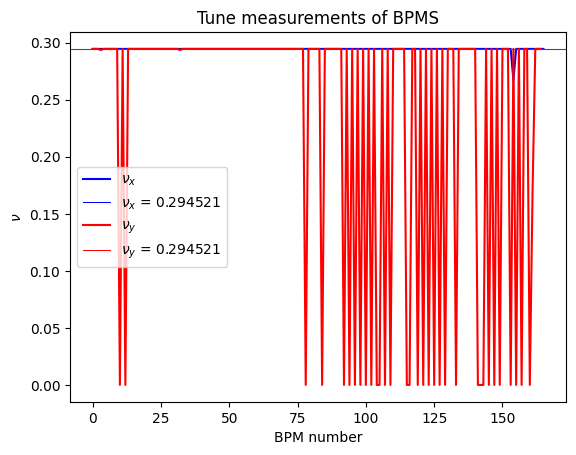

In [9]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [16]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM
print(Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print(Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

[154]
[10, 12, 78, 84, 92, 94, 96, 98, 100, 102, 104, 105, 107, 109, 115, 116, 119, 121, 123, 125, 127, 129, 133, 141, 142, 143, 145, 147, 149, 153, 155, 157, 160, 161]


## Phase Transfer Matrix Calculation

In [17]:
print(Name_ybpms[0:])
print(S_ybpms[0][0:])

['rbpm.b-g6-bvx', 'rbpm.bo6-bv1', 'rbpm.bo6-bv3', 'rbpm.bo6-bv3.1', 'rbpm.bo6-bv4', 'rbpm.bo6-bv5', 'rbpm.bo6-bv7', 'rbpm.bo6-bv8', 'rbpm.bo6-bv9', 'rbpm.bo6-bv11', 'rbpm.bo6-bv13', 'rbpm.bo6-bv15', 'rbpm.bo6-bv17', 'rbpm.bo6-bv19', 'rbpm.bo7-bv21', 'rbpm.bo7-bv19', 'rbpm.bo7-bv17', 'rbpm.bo7-bv15', 'rbpm.bo7-bv13', 'rbpm.bo7-bv11', 'rbpm.bo7-bv9', 'rbpm.bo7-bv8', 'rbpm.bo7-bv7', 'rbpm.bo7-bv5', 'rbpm.bo7-bv4', 'rbpm.bo7-bv3.1', 'rbpm.bo7-bv3', 'rbpm.bo7-bv1', 'rbpm.b-g7-bvx', 'rbpm.b-g8-bvx', 'rbpm.bi8-bv1', 'rbpm.bi8-bv3', 'rbpm.bi8-bv3.1', 'rbpm.bi8-bv4', 'rbpm.bi8-bv6', 'rbpm.bi8-bv7', 'rbpm.bi8-bv8', 'rbpm.bi8-bv10', 'rbpm.bi8-bv12', 'rbpm.bi8-bv14', 'rbpm.bi8-bv16', 'rbpm.bi8-bv18', 'rbpm.bi8-bv20', 'rbpm.bi9-bv20', 'rbpm.bi9-bv18', 'rbpm.bi9-bv16', 'rbpm.bi9-bv14', 'rbpm.bi9-bv12', 'rbpm.bi9-bv10', 'rbpm.bi9-bv8', 'rbpm.bi9-bv7.1', 'rbpm.bi9-bv7', 'rbpm.bi9-bv6', 'rbpm.bi9-bv4', 'rbpm.bi9-bv3', 'rbpm.bi9-bv1', 'rbpm.b-g9-bvx', 'rbpm.b-g10-bvx', 'rbpm.bo10-bv1', 'rbpm.bo10-bv3', 

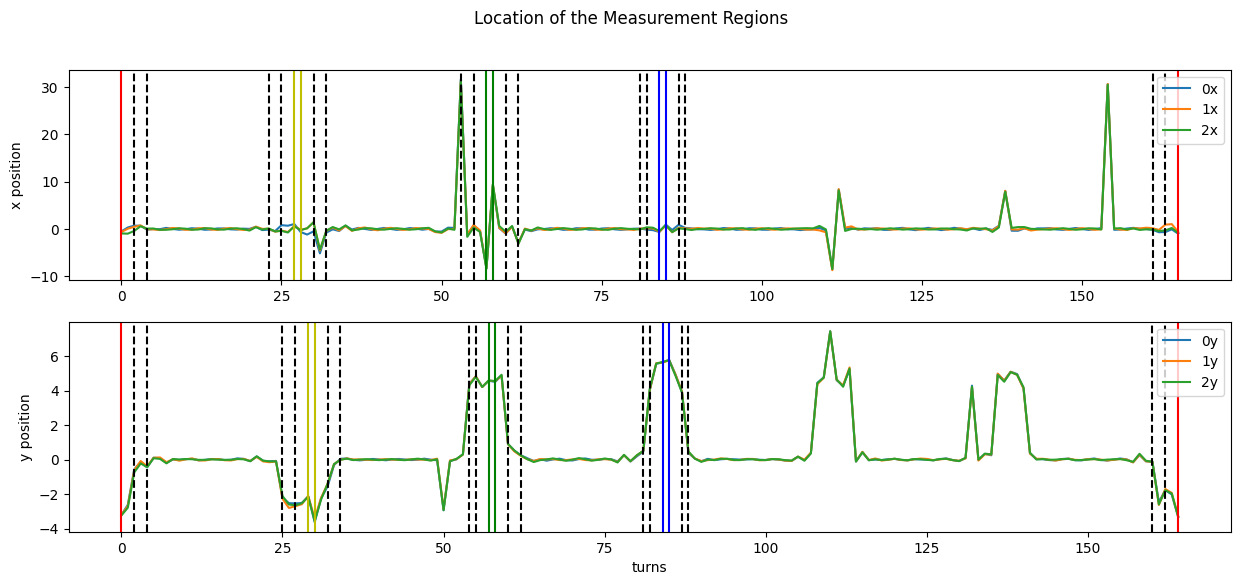

In [18]:
fig, Ax = plt.subplots(2, 1, figsize = (15, 6))
Ax[0].plot(Pos_xbpms[0, :], label = "0x")
Ax[0].plot(Pos_xbpms[1, :], label = "1x")
Ax[0].plot(Pos_xbpms[2, :], label = "2x")
Ax[0].legend()
fig.suptitle("Location of the Measurement Regions")

#IP6
Ax[0].axvline(x = len(Name_xbpms) - 5, color = 'k', ls = '--')
Ax[0].axvline(x = len(Name_xbpms) - 3, color = 'k', ls = '--')

Ax[0].axvline(x = len(Name_xbpms) - 1, color = 'r')
Ax[0].axvline(x = 0, color = 'r')

Ax[0].axvline(x = 2, color = 'k', ls = '--')
Ax[0].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[0].axvline(x = 23, color = 'k', ls = '--')
Ax[0].axvline(x = 25, color = 'k', ls = '--')

Ax[0].axvline(x = 27, color = 'y')
Ax[0].axvline(x = 28, color = 'y')

Ax[0].axvline(x = 30, color = 'k', ls = '--')
Ax[0].axvline(x = 32, color = 'k', ls = '--')

#IP10
Ax[0].axvline(x = 53, color = 'k', ls = '--')
Ax[0].axvline(x = 55, color = 'k', ls = '--')

Ax[0].axvline(x = 57, color = 'g')
Ax[0].axvline(x = 58, color = 'g')

Ax[0].axvline(x = 60, color = 'k', ls = '--')
Ax[0].axvline(x = 62, color = 'k', ls = '--')

#IP12
Ax[0].axvline(x = 81, color = 'k', ls = '--')
Ax[0].axvline(x = 82, color = 'k', ls = '--')

Ax[0].axvline(x = 84, color = 'b')
Ax[0].axvline(x = 85, color = 'b')

Ax[0].axvline(x = 87, color = 'k', ls = '--')
Ax[0].axvline(x = 88, color = 'k', ls = '--')

Ax[1].plot(Pos_ybpms[0, :], label = "0y")
Ax[1].plot(Pos_ybpms[1, :], label = "1y")
Ax[1].plot(Pos_ybpms[2, :], label = "2y")
Ax[1].legend()

#IP6
Ax[1].axvline(x = len(Name_ybpms) - 5, color = 'k', ls = '--')
Ax[1].axvline(x = len(Name_ybpms) - 3, color = 'k', ls = '--')

Ax[1].axvline(x = len(Name_ybpms) - 1, color = 'r')
Ax[1].axvline(x = 0, color = 'r')

Ax[1].axvline(x = 2, color = 'k', ls = '--')
Ax[1].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[1].axvline(x = 25, color = 'k', ls = '--')
Ax[1].axvline(x = 27, color = 'k', ls = '--')

Ax[1].axvline(x = 29, color = 'y')
Ax[1].axvline(x = 30, color = 'y')

Ax[1].axvline(x = 32, color = 'k', ls = '--')
Ax[1].axvline(x = 34, color = 'k', ls = '--')

#IP10
Ax[1].axvline(x = 54, color = 'k', ls = '--')
Ax[1].axvline(x = 55, color = 'k', ls = '--')

Ax[1].axvline(x = 57, color = 'g')
Ax[1].axvline(x = 58, color = 'g')

Ax[1].axvline(x = 60, color = 'k', ls = '--')
Ax[1].axvline(x = 62, color = 'k', ls = '--')

#IP12
Ax[1].axvline(x = 81, color = 'k', ls = '--')
Ax[1].axvline(x = 82, color = 'k', ls = '--')

Ax[1].axvline(x = 84, color = 'b')
Ax[1].axvline(x = 85, color = 'b')

Ax[1].axvline(x = 87, color = 'k', ls = '--')
Ax[1].axvline(x = 88, color = 'k', ls = '--')

Ax[0].set_ylabel("x position")
Ax[1].set_xlabel("turns")
Ax[1].set_ylabel("y position")

plt.show()

## Linear Regression Calculation

In [19]:
def Mat_param2D(result):
    M = result.coef_
    print("M:")
    print(M)

    det = np.linalg.det(M)
    print("determinant:", det)
    M /= (np.sqrt(det))
    print("determinant after normalization:", np.linalg.det(M))
    print("M after normalization:")
    print(M)
    return M, det
    
def Twiss_calc2D(M):
    if M[0, 1] > 0:
        phi = np.arccos((M[0, 0] + M[1, 1])/2)
    else: phi = 2*np.pi - np.arccos((M[0, 0] + M[1, 1])/2)
    beta = M[0, 1]/np.sin(phi)
    alpha = (M[0, 0] - M[1, 1])/(2*np.sin(phi))

    tune = phi/(2*np.pi)
    print("tune:", tune)
    Twiss = np.array([phi, beta, alpha, tune])

    return Twiss

In [40]:
from scipy.spatial import ConvexHull
def LR_calculation2D(Interval, BPM, S_bpms, Bpms, b_MADx, Name, ishor):
    bpm1, bpm2 = Bpms
    b1_m, b2_m = b_MADx
    
    #Organize position and speed data
    initial_turn, interval_turn = Interval
        
    # Scaled position and speed between two bpms
    C = 3834
    if S_bpms[0, bpm1] > S_bpms[0, bpm2]: L = S_bpms[0, bpm2] - S_bpms[0, bpm1] + C
    else: L = S_bpms[0, bpm2] - S_bpms[0, bpm1]
    x_data1_all = BPM[bpm1] - np.mean(BPM[bpm1])
    x_data2_all = BPM[bpm2] - np.mean(BPM[bpm2])
    xp_data_all = (x_data2_all - x_data1_all)/L
#     if S_bpms[0, bpm1] > S_bpms[0, bpm2]:
#         xp_data_all = -xp_data_all

    # variable data: x_data (bpm, var) (current turn)
    x_data11 = x_data1_all[initial_turn: initial_turn + interval_turn]
    x_data12 = xp_data_all[initial_turn: initial_turn + interval_turn]

    x_data21 = x_data2_all[initial_turn: initial_turn + interval_turn]
    x_data22 = xp_data_all[initial_turn: initial_turn + interval_turn]

    X_data1 = np.vstack((x_data11, x_data12)).T
    X_data2 = np.vstack((x_data21, x_data22)).T

    # Y Train data (next turn)
    y_data11 = x_data1_all[initial_turn + 1: initial_turn + interval_turn + 1]
    y_data12 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

    y_data21 = x_data2_all[initial_turn + 1: initial_turn + interval_turn + 1]
    y_data22 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

    Y_data1 = np.vstack((y_data11, y_data12)).T
    Y_data2 = np.vstack((y_data21, y_data22)).T
    print(np.max(x_data1_all) - np.min(x_data1_all))
    print(np.max(x_data2_all) - np.min(x_data2_all))
    print(np.max(xp_data_all) - np.min(xp_data_all))
    print("ratio betwen x1 and xp:", (np.max(x_data1_all) - np.min(x_data1_all))/(np.max(xp_data_all) - np.min(xp_data_all)))
    print("ratio betwen x2 and xp:", (np.max(x_data2_all) - np.min(x_data2_all))/(np.max(xp_data_all) - np.min(xp_data_all)))
    
    # Compute the convex hull
    hull1 = ConvexHull(X_data1)
    hull2 = ConvexHull(X_data2)
    
    # Calculate the area of the convex hull
    area1 = hull1.volume
    print("Area of the convex hull1:", area1)
    area2 = hull2.volume
    print("Area of the convex hull2:", area2)
            
    #LR Calculation:
    # Y = MX + B; M: 2x2
    result1 = LinearRegression().fit(X_data1, Y_data1)
    result2 = LinearRegression().fit(X_data2, Y_data2)

    #Correlation:
    corr1 = result1.score(X_data1, Y_data1)
    corr2 = result2.score(X_data2, Y_data2)
    print("Correlation from bpm 1 & 2:", corr1, corr2)
    print()
    
    #Prediction: Visualize correlation
    pred1 = result1.predict(X_data1)
    pred2 = result2.predict(X_data2)
    fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
    Ax[0].scatter(pred1, Y_data1)
    Ax[0].set_title("prediction vs real for left bpm")
    Ax[0].set_xlabel("predicted next turn values")
    Ax[0].set_ylabel("Actual next turn values")
    
    Ax[1].scatter(pred2, Y_data2)
    Ax[1].set_title("prediction vs real for right bpm")
    Ax[1].set_xlabel("predicted next turn values")
    Ax[1].set_ylabel("Actual next turn values")
    plt.show()
    print()
    
    # Get Matrix M
    M1, det1 = Mat_param2D(result1)
    M2, det2 = Mat_param2D(result2)
    
    # Calculate Twiss parameters
    Twiss1 = Twiss_calc2D(M1)
    Twiss2 = Twiss_calc2D(M2)
    phi1, b1, alpha1, tune1 = Twiss1
    phi2, b2, alpha2, tune2 = Twiss2
    print("phix, betax, alphaxy:")
    print(phi1, b1, alpha1, phi2, b2, alpha2)
    print("Measured Beta for left bpm:", b1)
    print("Model Beta for left bpm:", b1_m)
    print("Measured Beta for right bpm:", b2)
    print("Model Beta for right bpm:", b2_m)
    print()
    beat1 = (b1_m - b1)/b1_m
    beat2 = (b2_m - b2)/b2_m

    print("Measured Beta for bpm 1, 2:", b1, b2)
    print()
    print("beta beat at bpm 1, 2:")
    print(beat1, beat2)
    print()
    print()
    if ishor: axis = "x"
    else: axis = "y"
        
    fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
    Ax[0].scatter(x_data11, x_data12)
    Ax[0].set_ylabel("%s' [mm]"%axis)
    Ax[0].set_xlabel("%s [mm], %s"%(axis, Name[bpm1]))
    
    Ax[1].scatter(x_data21, x_data22)
    Ax[1].set_ylabel("%s' [mm]"%axis)
    Ax[1].set_xlabel("%s [mm], %s"%(axis, Name[bpm2]))
    
    
    return np.array([corr1, corr2, det1, det2, tune1, tune2, beat1, beat2])

In [37]:
def bpm_signals2D(Bpms, BPM, Intervals, ishor):
    x = np.linspace(0, N_turns, N_turns)
    fig, Ax = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle("BPM TBT Data")

    for i, bpm in enumerate(Bpms):
        iterx = i//2
        itery = i%2
        BPM0 = BPM[bpm]
        BPM0_mean = np.mean(BPM0)

        Ax[i].plot(x, BPM0)
        Ax[i].axhline(y = BPM0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPM0_mean)
        Ax[i].axvline(x = Intervals[0], color = 'k', linestyle = '--', linewidth = .75)
        Ax[i].axvline(x = Intervals[0] + Intervals[1], color = 'k', linestyle = '--', linewidth = .75)
        Ax[i].set_xlim((0, 100))
        if itery == 0:
            if ishor: Ax[i].set_ylabel("Horizontal Offset [mm]")
            else: Ax[i].set_ylabel("Vertical Offset [mm]")
        if iterx == 1:
            if itery == 0: Ax[i].set_xlabel("Turns, %s"%Name_xbpms[bpm])
            else: Ax[i].set_xlabel("Turns, %s"%Name_ybpms[bpm])
        Ax[i].legend()
    plt.show()

In [22]:
def chrom2D(Interval_range, BPM, S_bpms, Bpms, b_MADx, is_hor):
    N = len(Interval_range)
    Beta1 = np.zeros(N)
    Beta2 = np.zeros(N)
    for i, interval in enumerate(Interval_range):
        interval = int(interval)
        if is_hor: Intervals = (30, interval)
        else: Intervals = (550, interval)
        Twiss1, Twiss2 = LR_calculation2D(Intervals, BPM, S_bpms, Bpms, b_MADx)
        Beta1[i] = Twiss1[1]
        Beta2[i] = Twiss2[1]
    fig, Ax = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle("Nonlinearity")
    Ax[0].plot(Interval_range, Beta1, label = "beta measured")
    Ax[0].plot(Interval_range, (b_MADx[0] - Beta1), color = 'r', alpha = .5, label = "scaled beta beat")
    
    Ax[1].plot(Interval_range, Beta2, label = "beta measured")
    Ax[1].plot(Interval_range, (b_MADx[1] - Beta2), color = 'r', alpha = .5,  label = "scaled beta beat")
    
    for i in range(2):
        Ax[i].axhline(y = b_MADx[i], color = 'k', linestyle = '--', linewidth = .75, label = "beta model")
        Ax[i].set_ylim(-b_MADx[i], b_MADx[i]*2)
        Ax[i].set_ylabel("Beta value [m]")
        Ax[i].set_xlabel("Intervals")
    plt.legend()
    plt.show()
#     return Beta1, Beta2

### Around IP6

Bad Horizontal BPMs: [154]
Bad Vertical BPMs: [10, 12, 78, 84, 92, 94, 96, 98, 100, 102, 104, 105, 107, 109, 115, 116, 119, 121, 123, 125, 127, 129, 133, 141, 142, 143, 145, 147, 149, 153, 155, 157, 160, 161]


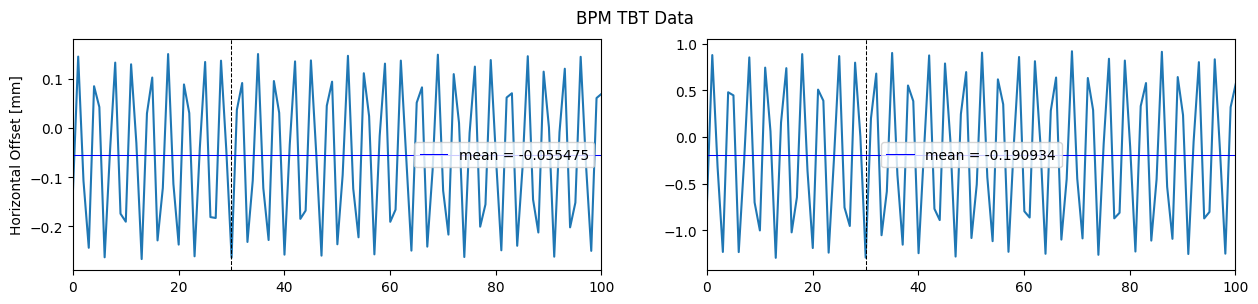

0.42705592343663634
2.2507308159724113
0.0504925142774473
ratio betwen x1 and xp: 8.457806658033322
ratio betwen x2 and xp: 44.575534575383784
Area of the convex hull1: 0.0024500229456138516
Area of the convex hull2: 0.002450022945613853
Correlation from bpm 1 & 2: 0.9858271225329632 0.9851502098563183



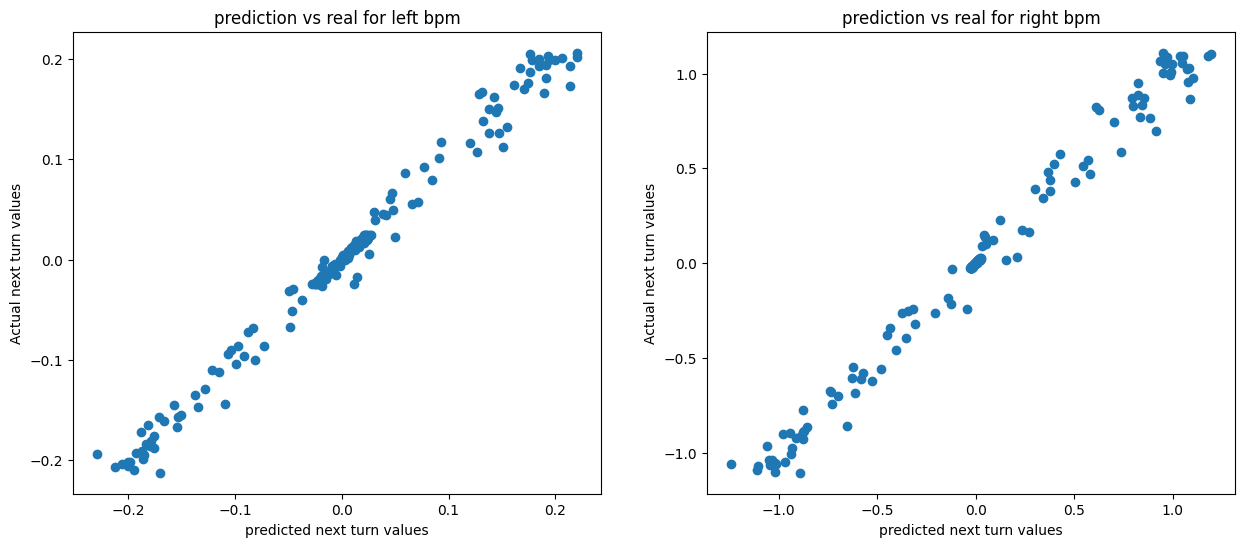


M:
[[  6.53167138 -57.70036649]
 [  0.81832052  -7.07827893]]
determinant: 0.9844020892999691
determinant after normalization: 0.9999999999999916
M after normalization:
[[  6.58321537 -58.15570277]
 [  0.82477821  -7.13413641]]
M:
[[   36.23595346 -1629.96715326]
 [    0.81832052   -36.78256101]]
determinant: 0.9844020893003684
determinant after normalization: 0.9999999999999818
M after normalization:
[[   36.52190562 -1642.82986501]
 [    0.82477821   -37.07282667]]
tune: 0.7055848325937029
tune: 0.705584832593713
phix, betax, alphaxy:
4.433320253121522 60.496154772855355 -7.134700441383935 4.433320253121585 1708.9448678070407 -38.27826079714458
Measured Beta for left bpm: 60.496154772855355
Model Beta for left bpm: 69.89614778
Measured Beta for right bpm: 1708.9448678070407
Model Beta for right bpm: 1933.441666

Measured Beta for bpm 1, 2: 60.496154772855355 1708.9448678070407

beta beat at bpm 1, 2:
0.13448513695964162 0.11611252728271307




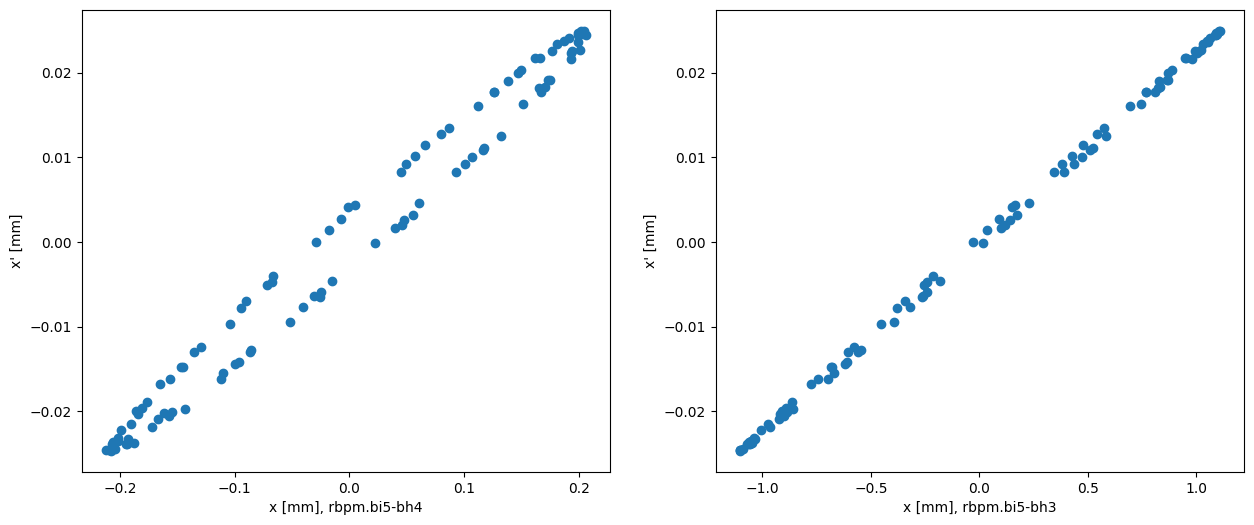

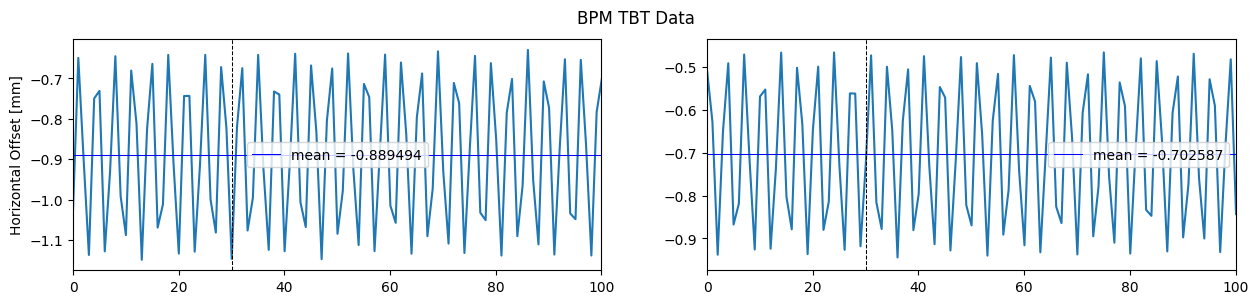

0.5198340666628212
0.48938556533519023
0.04128559860314253
ratio betwen x1 and xp: 12.5911718432309
ratio betwen x2 and xp: 11.853662824158247
Area of the convex hull1: 0.011578464469549596
Area of the convex hull2: 0.011578464469549597
Correlation from bpm 1 & 2: 0.9986713320242349 0.9990773969741262



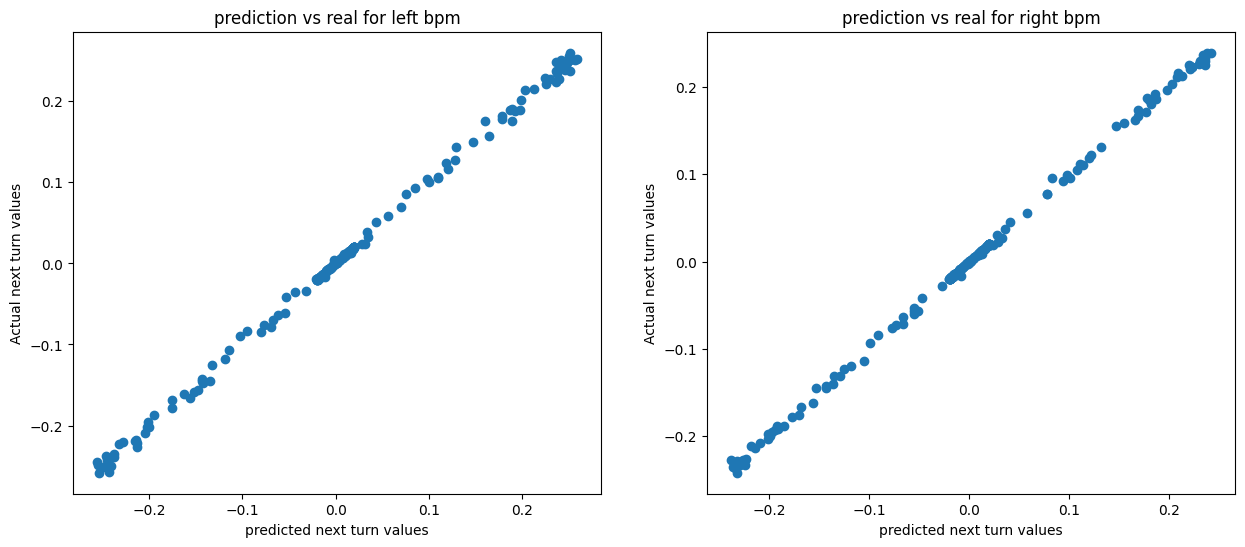


M:
[[ 0.67549382 17.06082823]
 [-0.10707817 -1.22669715]]
determinant: 0.9982159693910153
determinant after normalization: 1.0000000000000002
M after normalization:
[[ 0.67609717 17.07606714]
 [-0.10717382 -1.22779285]]
M:
[[-1.0885468  14.78489436]
 [-0.10707817  0.53734346]]
determinant: 0.998215969391015
determinant after normalization: 0.9999999999999998
M after normalization:
[[-1.0895191  14.79810039]
 [-0.10717382  0.53782342]]
tune: 0.2944792948672553
tune: 0.2944792948672553
phix, betax, alphaxy:
1.8502679787785437 17.765338907927674 0.9903700682433932 1.8502679787785434 15.395422518093696 -0.8465149242184842
Measured Beta for left bpm: 17.765338907927674
Model Beta for left bpm: 106.2277302
Measured Beta for right bpm: 15.395422518093696
Model Beta for right bpm: 99.91617133

Measured Beta for bpm 1, 2: 17.765338907927674 15.395422518093696

beta beat at bpm 1, 2:
0.8327617574574923 0.8459166087614969




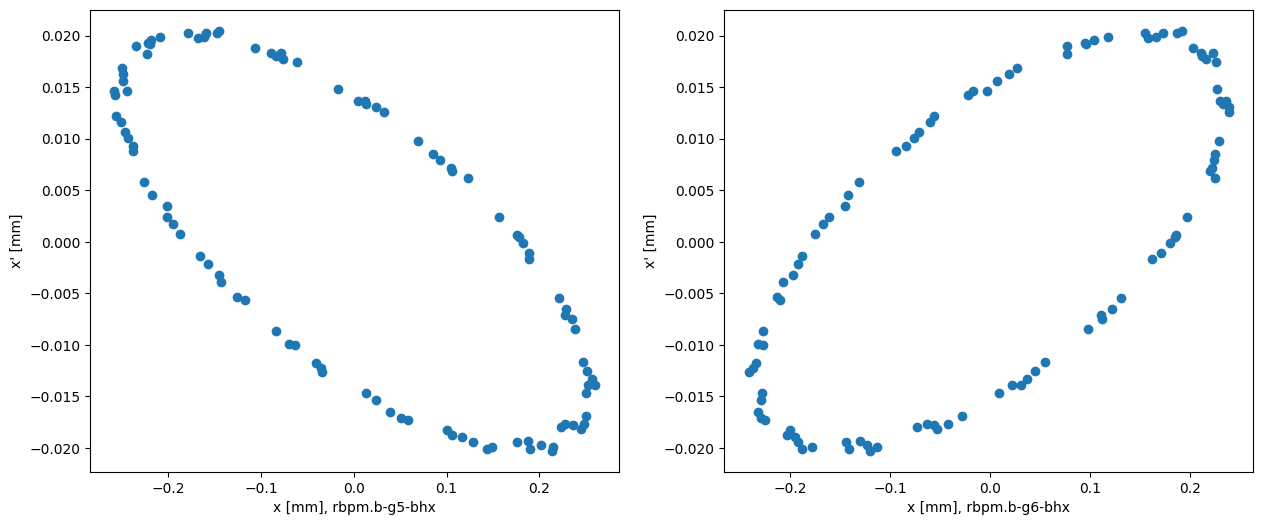

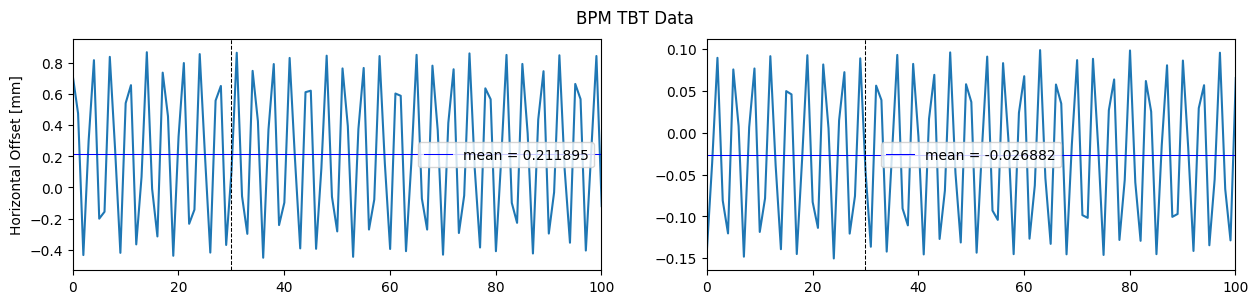

1.3499661623200505
0.2512068332650408
0.04397446949953501
ratio betwen x1 and xp: 30.698861809676295
ratio betwen x2 and xp: 5.712560859152537
Area of the convex hull1: 0.0022689672021777704
Area of the convex hull2: 0.0022689672021777713
Correlation from bpm 1 & 2: 0.997333620037735 0.9975314071994342



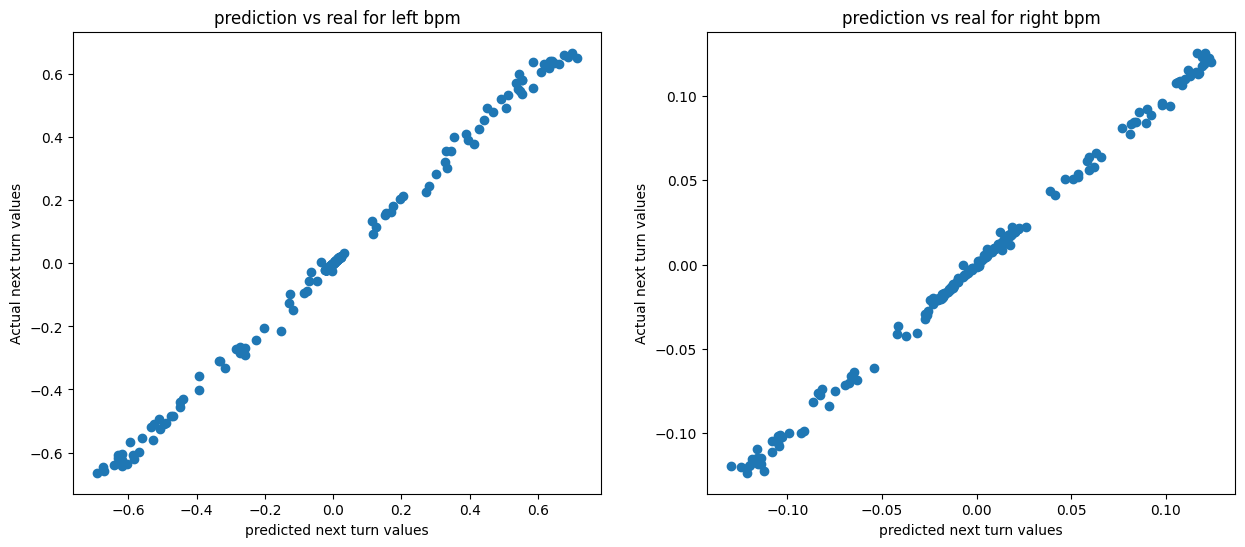


M:
[[ -19.51603392 -593.62428913]
 [   0.62520607   18.96607159]]
determinant: 0.9950135298730843
determinant after normalization: 0.9999999999999654
M after normalization:
[[ -19.56487472 -595.10989228]
 [   0.62677071   19.01353605]]
M:
[[  3.17839988 -20.54560903]
 [  0.62520607  -3.72836221]]
determinant: 0.9950135298731745
determinant after normalization: 0.9999999999999984
M after normalization:
[[  3.18635414 -20.59702643]
 [  0.62677071  -3.7376928 ]]
tune: 0.705550261351862
tune: 0.7055502613518642
phix, betax, alphaxy:
4.433103035602737 619.0983907800435 20.06674089654236 4.43310303560275 21.427279375115862 -3.6015754172279792
Measured Beta for left bpm: 619.0983907800435
Model Beta for left bpm: 712.3804574
Measured Beta for right bpm: 21.427279375115862
Model Beta for right bpm: 22.30481445

Measured Beta for bpm 1, 2: 619.0983907800435 21.427279375115862

beta beat at bpm 1, 2:
0.13094416845797724 0.03934285473888514




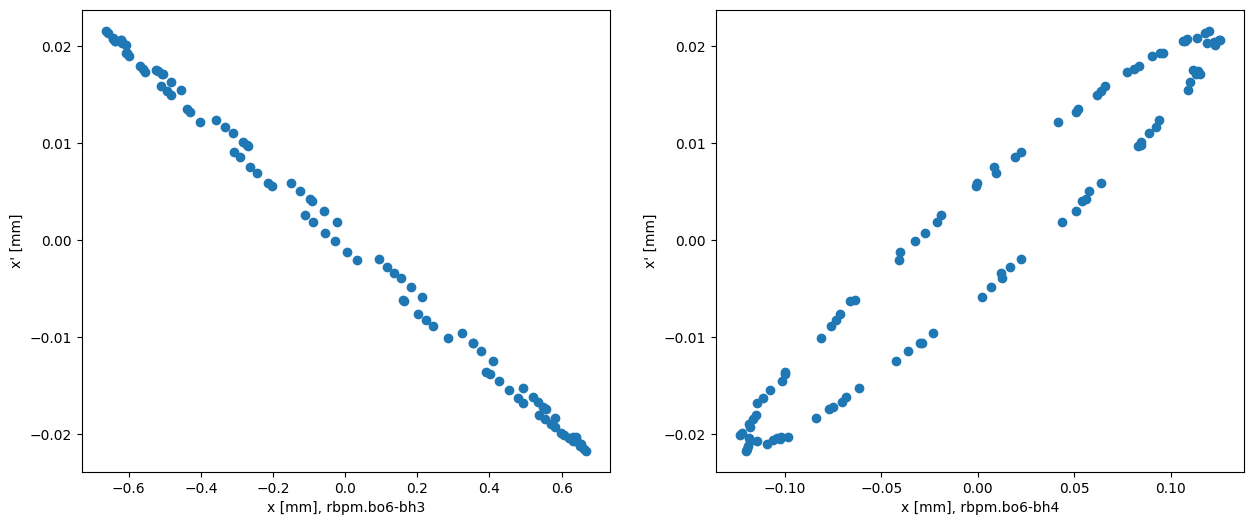

In [42]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP6
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = len(Name_xbpms) - 5, len(Name_xbpms) - 3
Bpmsy = len(Name_ybpms) - 5, len(Name_ybpms) - 3
b_MADxx = [69.89614778, 1933.441666]
b_MADxy = [22.51513094, 723.9572063]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res6xb = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.array([Bpmsx])

#at IP6
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = len(Name_xbpms) - 1, 0
Bpmsy = len(Name_ybpms) - 1, 0
b_MADxx = [106.2277302, 99.91617133]
b_MADxy = [109.6182312, 99.95490527]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res6x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

# #upstream of IP6
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 2, 4
b_MADxx = [712.3804574, 22.30481445] 
Bpmsy = 2, 4
b_MADxy = [1967.07171, 68.96725837]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res6xa = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

### Around IP8

Bad Horizontal BPMs: [154]
Bad Vertical BPMs: [10, 12, 78, 84, 92, 94, 96, 98, 100, 102, 104, 105, 107, 109, 115, 116, 119, 121, 123, 125, 127, 129, 133, 141, 142, 143, 145, 147, 149, 153, 155, 157, 160, 161]


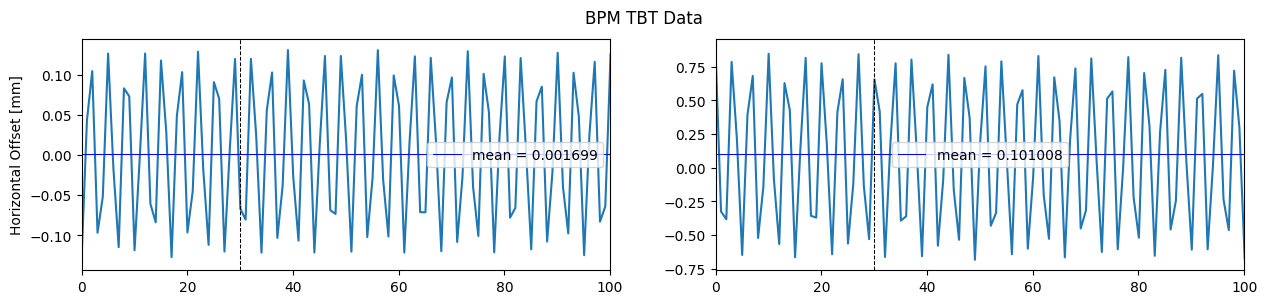

Correlation from bpm 1 & 2: 0.9981366771691673 0.9980995760843693



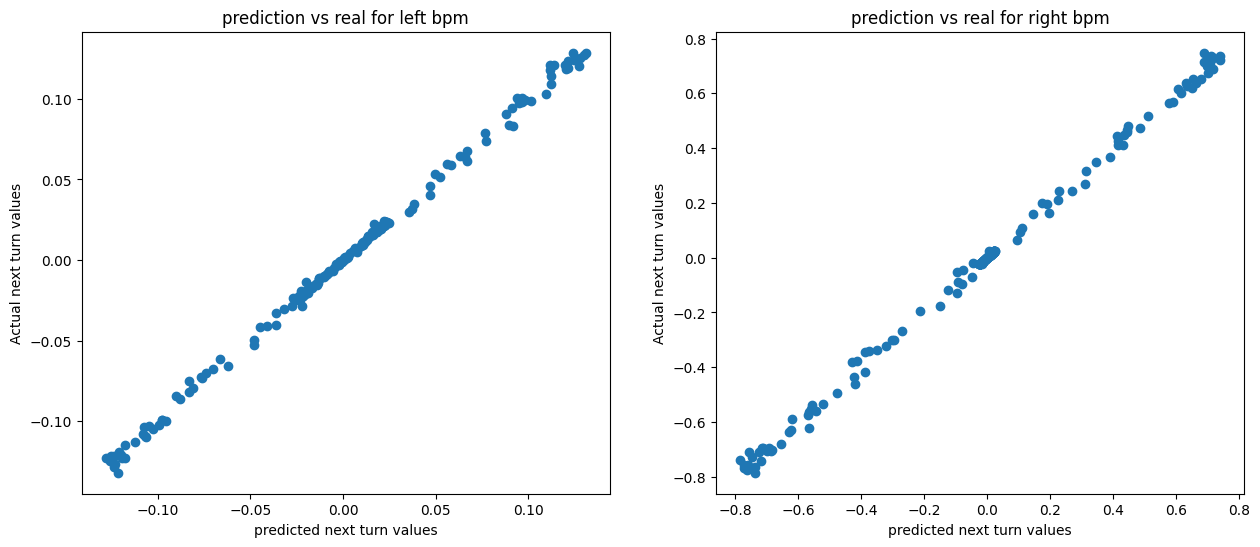


M:
[[ -4.3476714  -21.93647806]
 [  0.79800283   3.79696574]]
determinant: 0.997412110776583
determinant after normalization: 0.9999999999999969
M after normalization:
[[ -4.35330799 -21.96491786]
 [  0.79903741   3.80188836]]
M:
[[  24.61913934 -777.76332663]
 [   0.79800283  -25.169845  ]]
determinant: 0.9974121107767284
determinant after normalization: 1.0000000000000067
M after normalization:
[[  24.6510571  -778.77166683]
 [   0.79903741  -25.20247673]]
tune: 0.7055435586998434
tune: 0.7055435586998478
phix, betax, alphaxy:
4.433060921598054 22.850585623103196 4.242014785175975 4.433060921598082 810.1732393963563 -25.93186213699132
Measured Beta for left bpm: 22.850585623103196
Model Beta for left bpm: 23.01275857
Measured Beta for right bpm: 810.1732393963563
Model Beta for right bpm: 770.9960485

Measured Beta for bpm 1, 2: 22.850585623103196 810.1732393963563

beta beat at bpm 1, 2:
0.007047088527153602 -0.0508137375964207




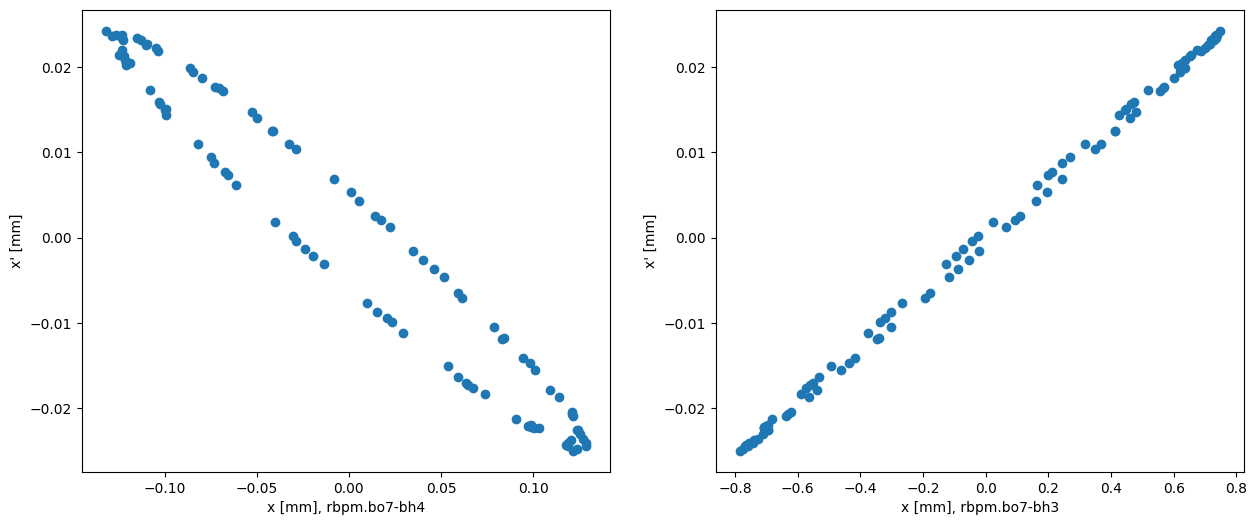

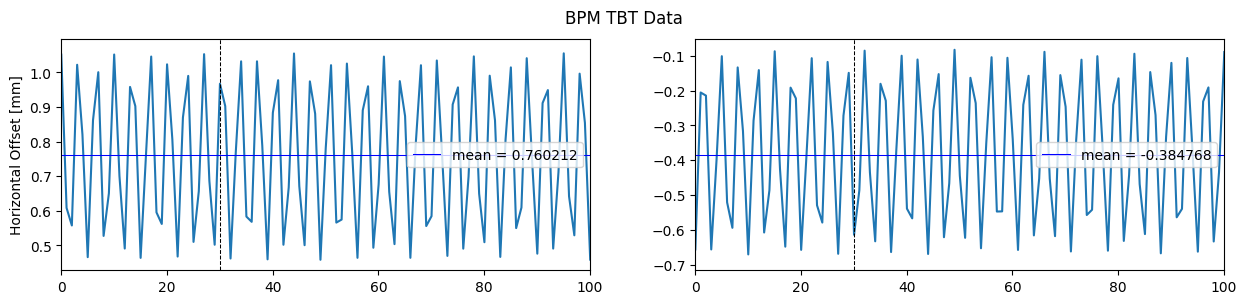

Correlation from bpm 1 & 2: 0.9957963045706588 0.995889550813079



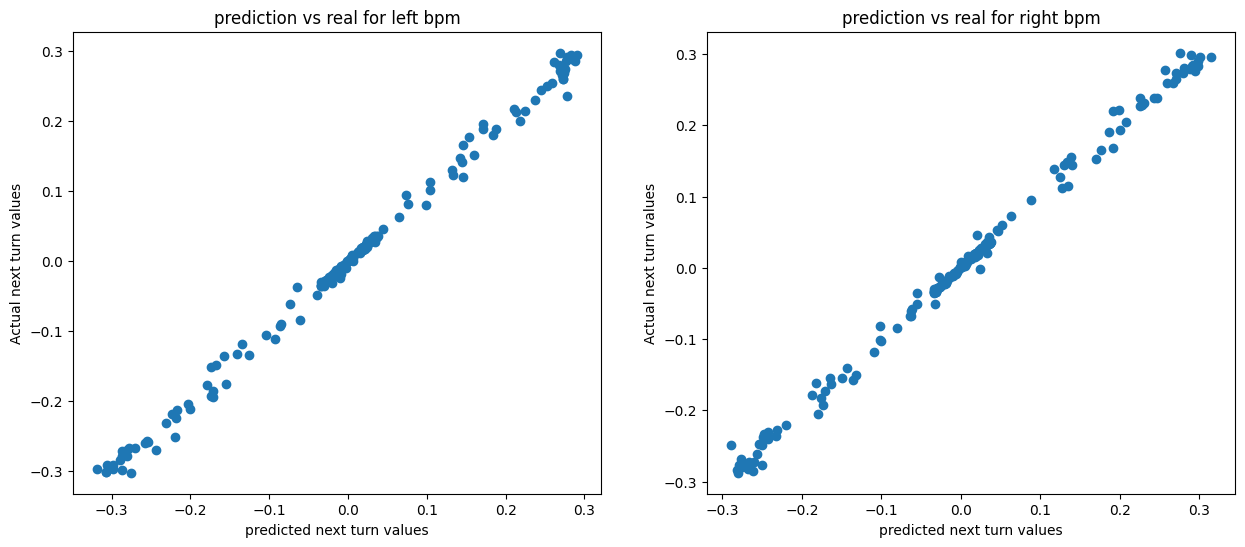


M:
[[ -13.94831813 -115.64131371]
 [   1.62463739   13.3980868 ]]
determinant: 0.9944255699124134
determinant after normalization: 0.9999999999999925
M after normalization:
[[ -13.98735839 -115.96498476]
 [   1.62918463   13.435587  ]]
M:
[[  13.10639635 -110.7838595 ]
 [   1.62463739  -13.65662768]]
determinant: 0.9944255699124195
determinant after normalization: 0.9999999999999751
M after normalization:
[[  13.14308013 -111.09393491]
 [   1.62918463  -13.69485152]]
tune: 0.7055144368055445
tune: 0.7055144368055445
phix, betax, alphaxy:
4.432877943339678 120.64725011249939 14.265094580105153 4.432877943339678 115.57952410718386 -13.96077729829567
Measured Beta for left bpm: 120.64725011249939
Model Beta for left bpm: 116.319434
Measured Beta for right bpm: 115.57952410718386
Model Beta for right bpm: 116.2980573

Measured Beta for bpm 1, 2: 120.64725011249939 115.57952410718386

beta beat at bpm 1, 2:
-0.03720630305422043 0.00617837657393215




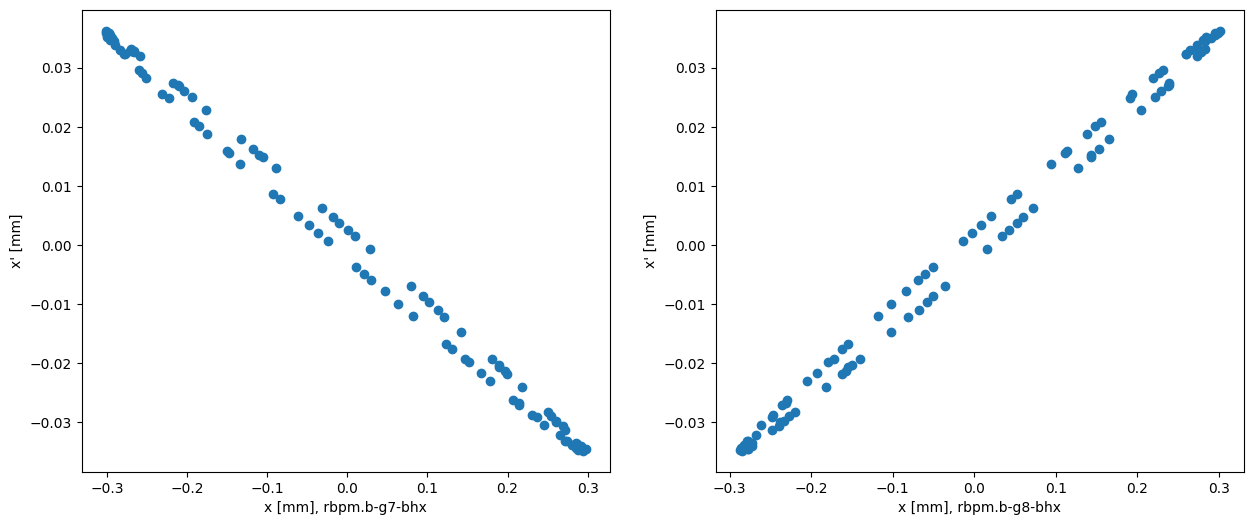

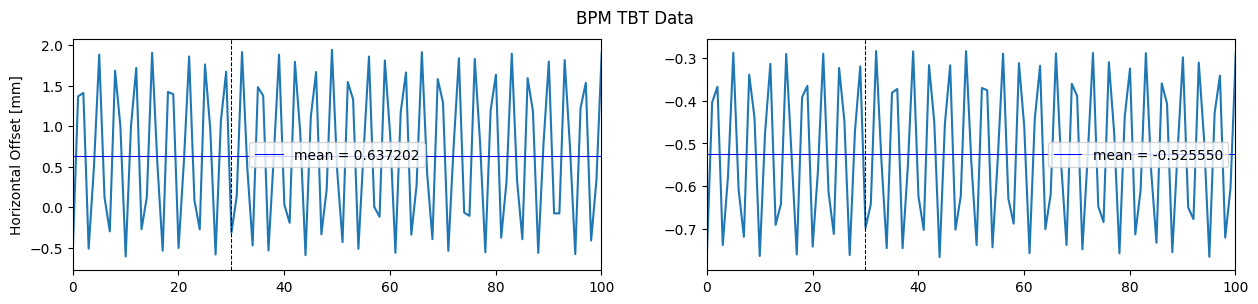

Correlation from bpm 1 & 2: 0.9789862159552395 0.9787250740723655



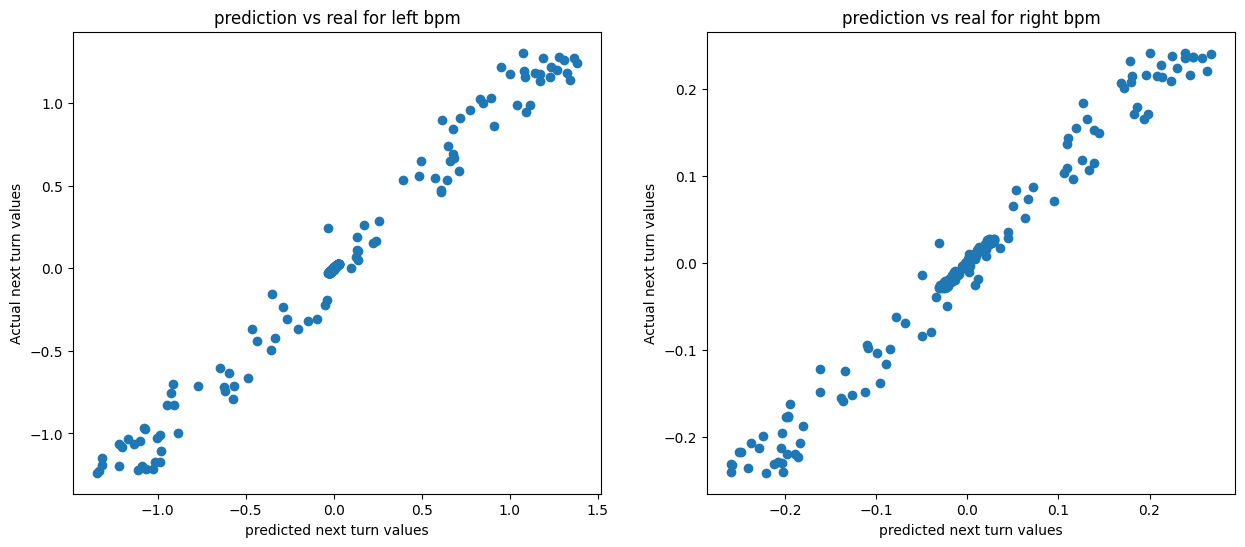


M:
[[  -47.01958445 -2097.98328597]
 [    1.04201192    46.47309202]]
determinant: 0.9781244427331375
determinant after normalization: 1.0000000000001212
M after normalization:
[[  -47.54246886 -2121.31404833]
 [    1.05359969    46.98989913]]
M:
[[ -9.19545505 -77.26329193]
 [  1.04201192   8.64896262]]
determinant: 0.978124442733607
determinant after normalization: 0.9999999999999867
M after normalization:
[[ -9.29771372 -78.12250349]
 [  1.05359969   8.74514398]]
tune: 0.7054483374751352
tune: 0.7054483374751483
phix, betax, alphaxy:
4.432462628998036 2207.2286835262694 49.180496000455804 4.432462628998119 81.28651703803294 9.38680274158651
Measured Beta for left bpm: 2207.2286835262694
Model Beta for left bpm: 2105.483966
Measured Beta for right bpm: 81.28651703803294
Model Beta for right bpm: 75.35080478

Measured Beta for bpm 1, 2: 2207.2286835262694 81.28651703803294

beta beat at bpm 1, 2:
-0.048323672452165144 -0.0787743710948184




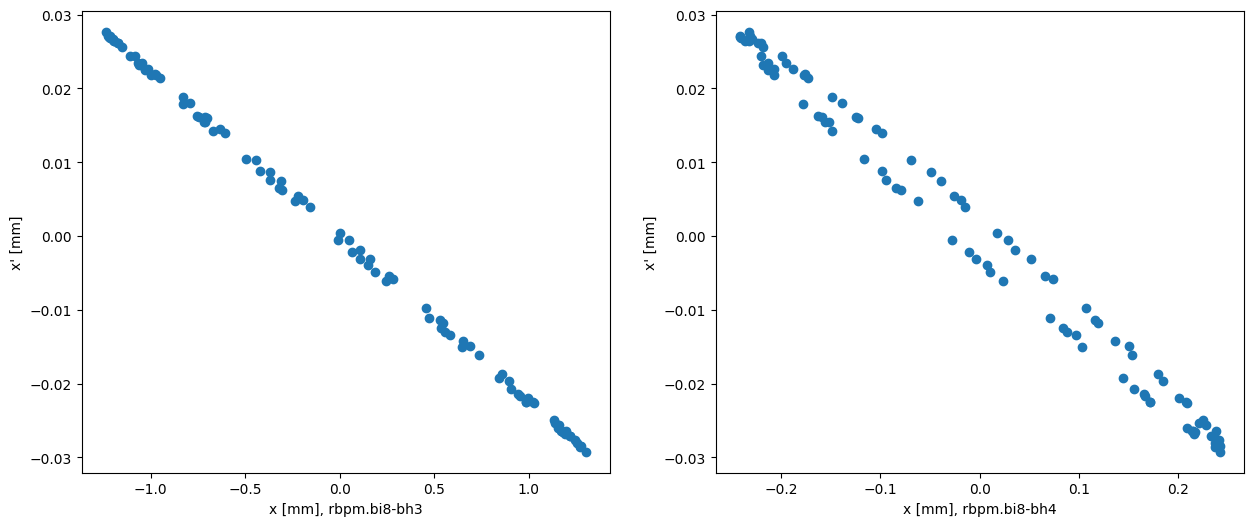

In [39]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 23, 25
Bpmsy = 24, 26
b_MADxx = [23.01275857, 770.9960485]
b_MADxy = [67.11826643, 1922.897826]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res8xb = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

#at IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 27, 28
Bpmsy = 29, 30
b_MADxx = [116.319434, 116.2980573]
b_MADxy = [106.2916138, 106.6106799]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res8x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

#upstream of IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 30, 32
b_MADxx = [2105.483966, 75.35080478] 
Bpmsy = 32, 34
b_MADxy = [705.0061522, 21.92479572]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res8xa = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

### Around IP10

Bad Horizontal BPMs: [154]
Bad Vertical BPMs: [10, 12, 78, 84, 92, 94, 96, 98, 100, 102, 104, 105, 107, 109, 115, 116, 119, 121, 123, 125, 127, 129, 133, 141, 142, 143, 145, 147, 149, 153, 155, 157, 160, 161]


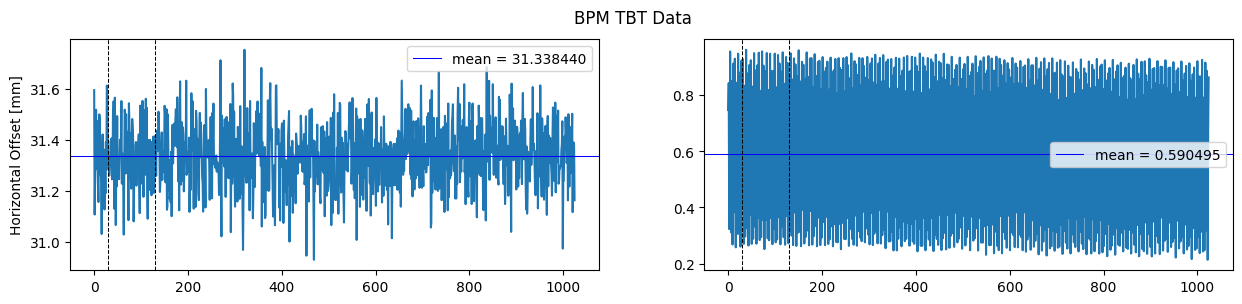

Correlation from bpm 1 & 2: 0.06666517452568099 0.08686386630944881



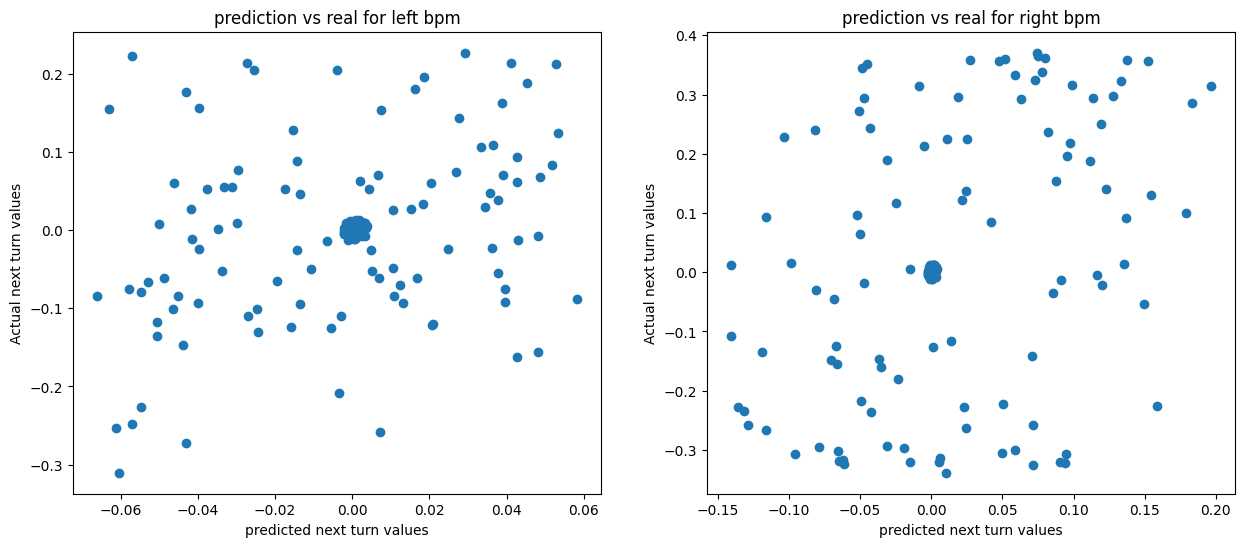


M:
[[-0.0607984  -5.51762197]
 [ 0.00475148 -0.18425308]]
determinant: 0.037419164500559154
determinant after normalization: 0.9999999999999998
M after normalization:
[[ -0.31430054 -28.52363688]
 [  0.02456303  -0.95250601]]
M:
[[  0.11155589 -16.24774037]
 [  0.00475148  -0.35660737]]
determinant: 0.0374191645005592
determinant after normalization: 1.0000000000000004
M after normalization:
[[  0.57669402 -83.99354811]
 [  0.02456303  -1.84350056]]
tune: 0.6408287262442066
tune: 0.6408287262442066
phix, betax, alphaxy:
4.0264456371562085 36.860727013474104 -0.41237233694348324 4.0264456371562085 108.54377583249915 -1.5637930787938013
Measured Beta for left bpm: 36.860727013474104
Model Beta for left bpm: 23.33458448
Measured Beta for right bpm: 108.54377583249915
Model Beta for right bpm: 189.6879326

Measured Beta for bpm 1, 2: 36.860727013474104 108.54377583249915

beta beat at bpm 1, 2:
-0.5796607411230021 0.4277771161047535




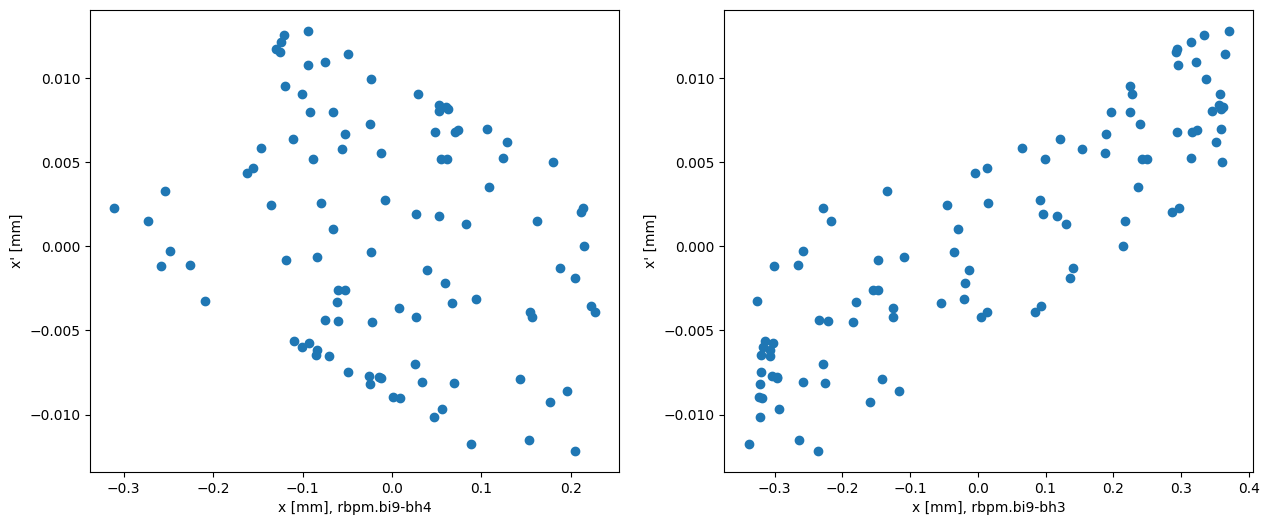

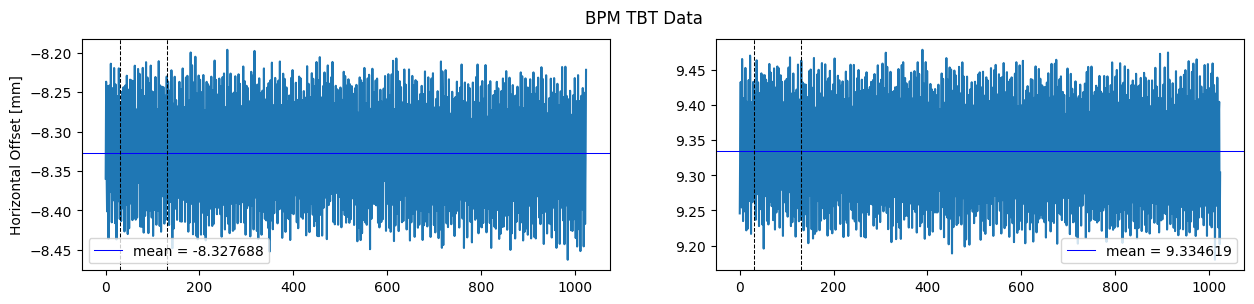

Correlation from bpm 1 & 2: 0.9599923793639688 0.9521653100883666



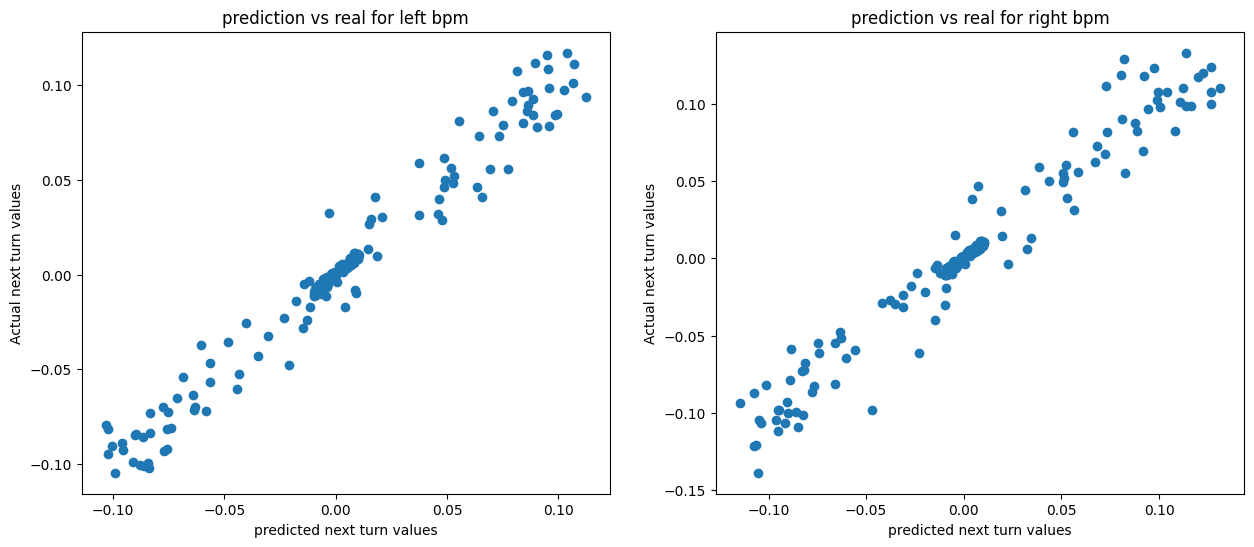


M:
[[ -1.25515871 -14.09929705]
 [  0.13161181   0.7149842 ]]
determinant: 0.9582153896447413
determinant after normalization: 0.9999999999999996
M after normalization:
[[ -1.28223337 -14.40342879]
 [  0.13445077   0.73040691]]
M:
[[  0.93656622 -17.78929133]
 [  0.13161181  -1.47674073]]
determinant: 0.9582153896447388
determinant after normalization: 0.9999999999999999
M after normalization:
[[  0.95676861 -18.17301883]
 [  0.13445077  -1.50859506]]
tune: 0.7055098780924233
tune: 0.7055098780924233
phix, betax, alphaxy:
4.432849300100375 14.985112671868158 1.0469604771185486 4.432849300100375 18.906937983797665 -1.2824638150814633
Measured Beta for left bpm: 14.985112671868158
Model Beta for left bpm: 16.60956293
Measured Beta for right bpm: 18.906937983797665
Model Beta for right bpm: 17.26537755

Measured Beta for bpm 1, 2: 14.985112671868158 18.906937983797665

beta beat at bpm 1, 2:
0.09780210743521599 -0.09507816606058896




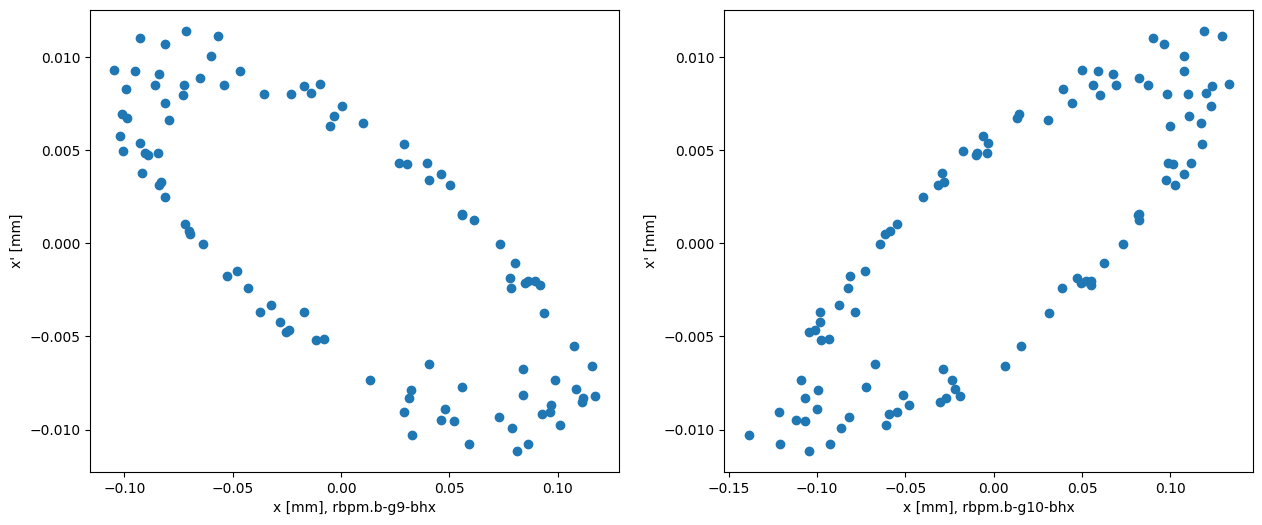

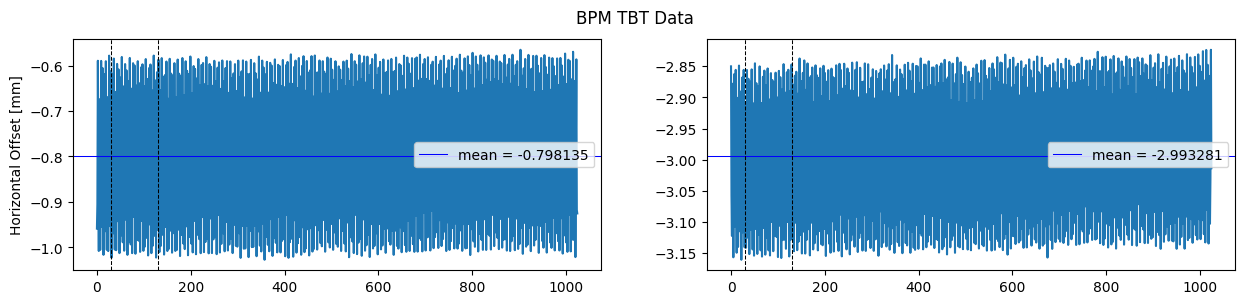

Correlation from bpm 1 & 2: 0.9951510750951398 0.9954518980142384



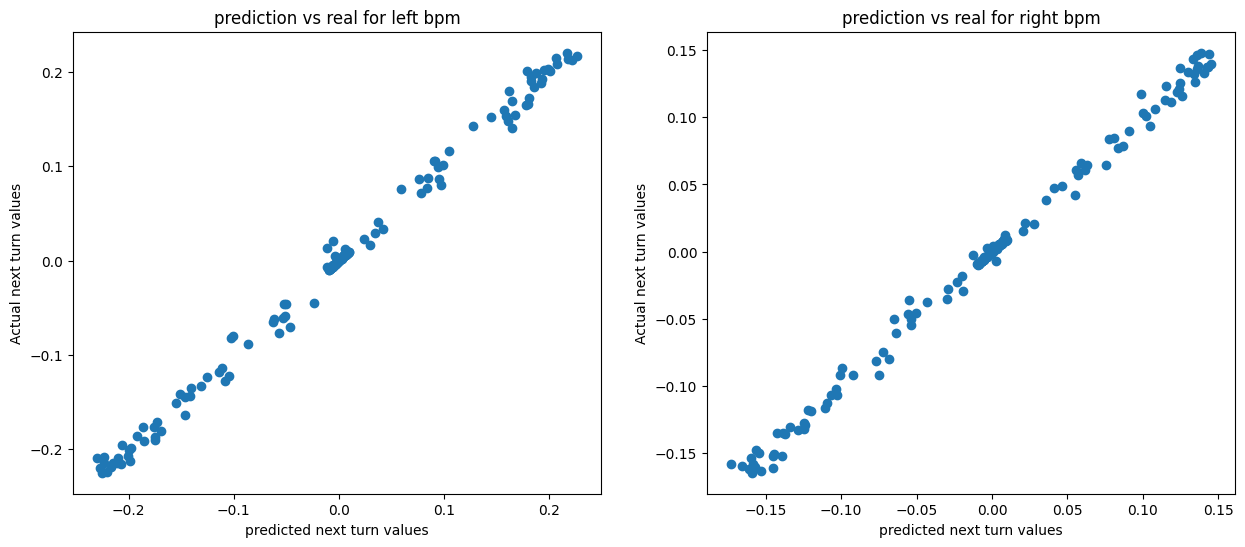


M:
[[ -2.91482926 -65.74180278]
 [  0.11996305   2.36502449]]
determinant: 0.9929446820302098
determinant after normalization: 1.0000000000000016
M after normalization:
[[ -2.92516652 -65.97495187]
 [  0.12038849   2.37341189]]
M:
[[  1.43667207 -32.06704443]
 [  0.11996305  -1.98647685]]
determinant: 0.9929446820302118
determinant after normalization: 1.0000000000000004
M after normalization:
[[  1.44176714 -32.18076815]
 [  0.12038849  -1.99352176]]
tune: 0.7055158246867238
tune: 0.7055158246867238
phix, betax, alphaxy:
4.432886663654312 68.6386206483531 2.7562514514659475 4.432886663654312 33.48003257088885 -1.786992526607364
Measured Beta for left bpm: 68.6386206483531
Model Beta for left bpm: 68.09359524
Measured Beta for right bpm: 33.48003257088885
Model Beta for right bpm: 30.20058549

Measured Beta for bpm 1, 2: 68.6386206483531 33.48003257088885

beta beat at bpm 1, 2:
-0.008004062737943603 -0.10858885772180606




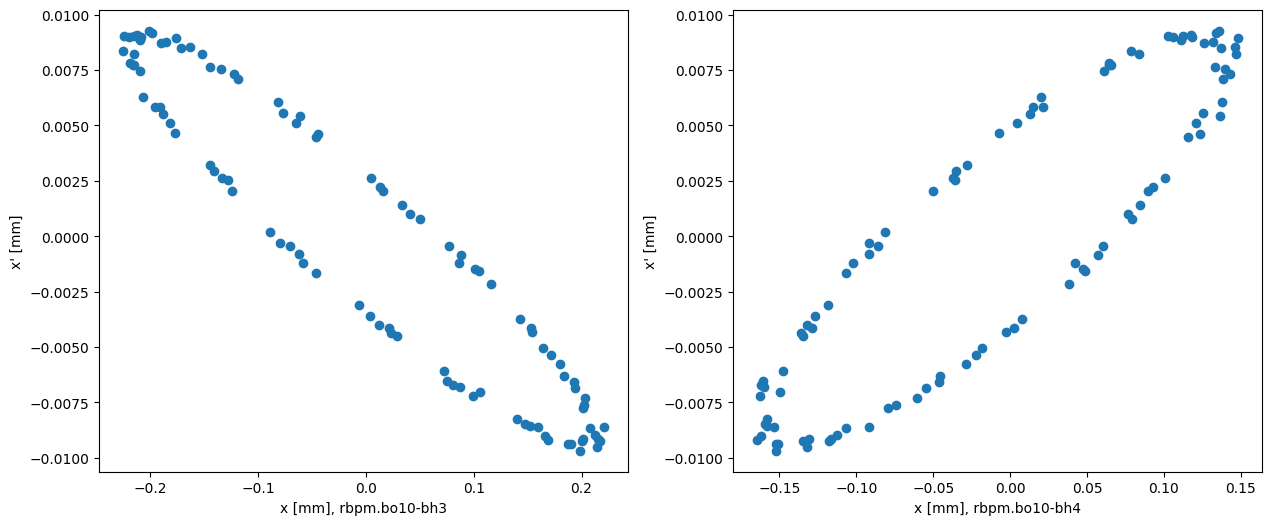

In [29]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP10
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 53, 55
Bpmsy = 54, 55
b_MADxx = [23.33458448, 189.6879326]
b_MADxy = [24.50151162, 69.40828357]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res10xb = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

#at IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 57, 58
Bpmsy = 57, 58
b_MADxx = [16.60956293, 17.26537755]
b_MADxy = [16.98000103, 16.87590121]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res10x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

#upstream of IP10
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 60, 62
b_MADxx = [68.09359524, 30.20058549] 
Bpmsy = 60, 62
b_MADxy = [191.6106402, 24.51697075]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res10xa = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

### Around IP12 

Bad Horizontal BPMs: [154]
Bad Vertical BPMs: [10, 12, 78, 84, 92, 94, 96, 98, 100, 102, 104, 105, 107, 109, 115, 116, 119, 121, 123, 125, 127, 129, 133, 141, 142, 143, 145, 147, 149, 153, 155, 157, 160, 161]


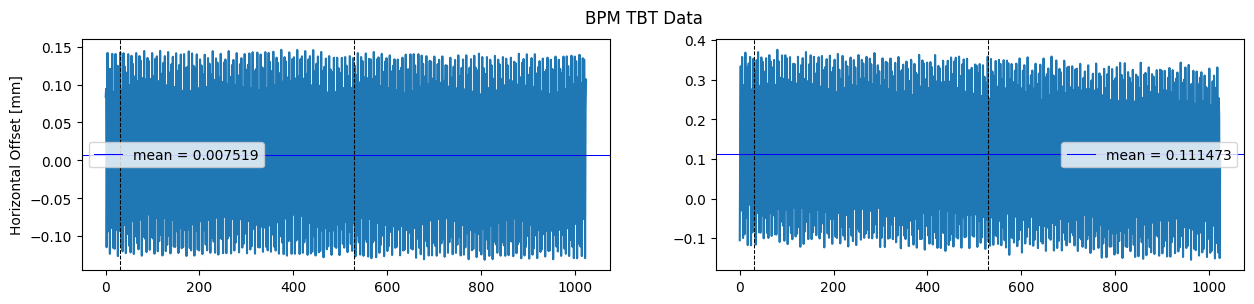

Correlation from bpm 1 & 2: 0.995175364538609 0.9966288616605494



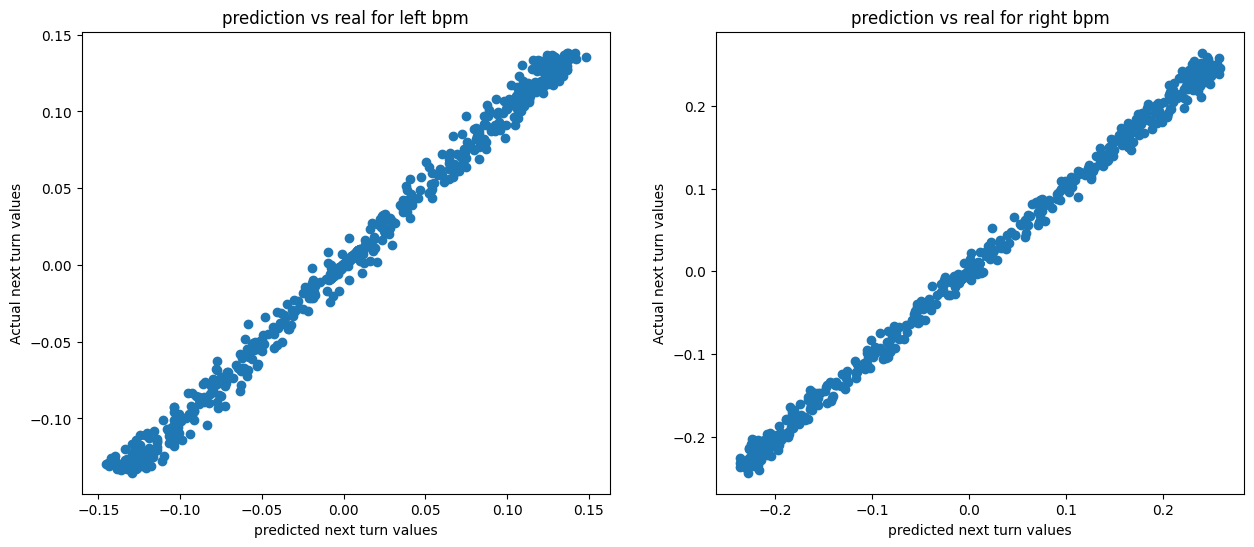


M:
[[ -1.77949975 -25.46689662]
 [  0.12506493   1.2314282 ]]
determinant: 0.9936894722874431
determinant after normalization: 0.9999999999999998
M after normalization:
[[ -1.78514125 -25.54763372]
 [  0.12546142   1.23533216]]
M:
[[  2.75706549 -80.80737572]
 [  0.12506493  -3.30513704]]
determinant: 0.9936894722874464
determinant after normalization: 0.9999999999999978
M after normalization:
[[  2.76580615 -81.06355743]
 [  0.12546142  -3.31561524]]
tune: 0.705676873001985
tune: 0.7056768730019851
phix, betax, alphaxy:
4.433898560062507 26.571388837143743 1.5707555250187708 4.433898560062508 84.3119691102851 -3.162559286675744
Measured Beta for left bpm: 26.571388837143743
Model Beta for left bpm: 27.8045429
Measured Beta for right bpm: 84.3119691102851
Model Beta for right bpm: 72.25234952

Measured Beta for bpm 1, 2: 26.571388837143743 84.3119691102851

beta beat at bpm 1, 2:
0.04435081228601164 -0.16690972224988912




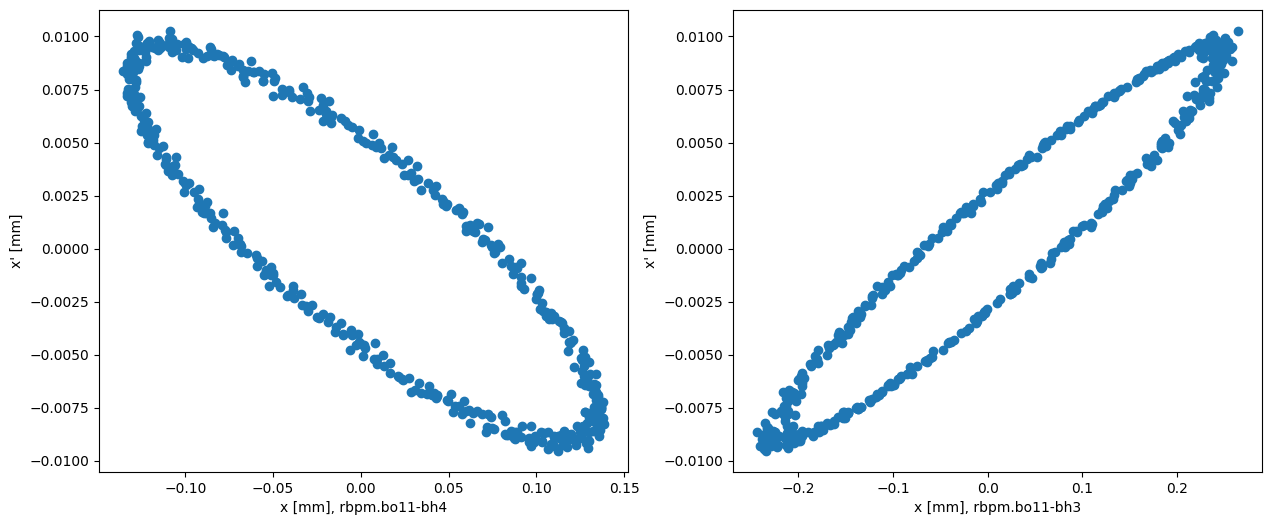

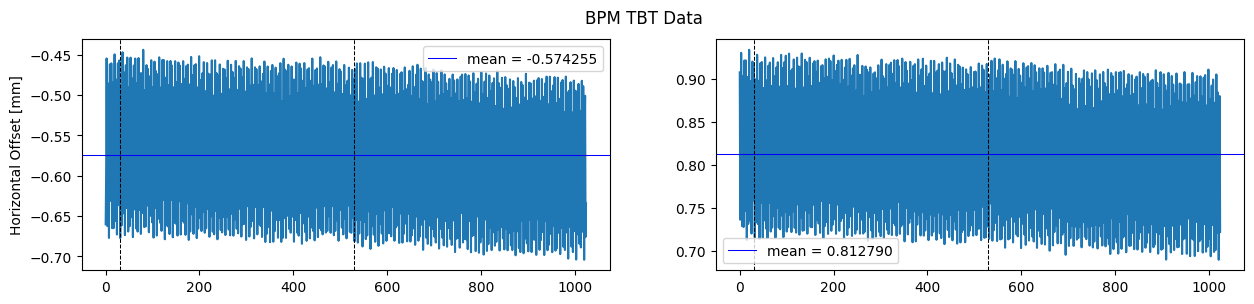

Correlation from bpm 1 & 2: 0.9883548632202628 0.9933039695670774



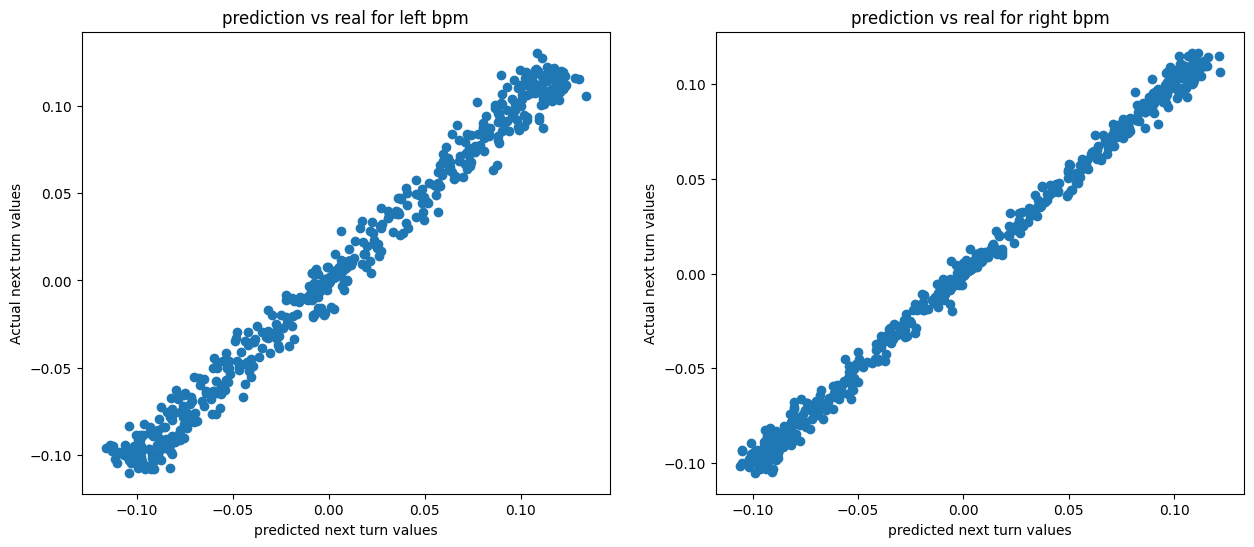


M:
[[ -1.72740264 -18.01429238]
 [  0.16827054   1.18190263]]
determinant: 0.9896529036499262
determinant after normalization: 1.0000000000000002
M after normalization:
[[ -1.7364094  -18.10821972]
 [  0.16914791   1.18806512]]
M:
[[  1.07475779 -16.23004042]
 [  0.16827054  -1.6202578 ]]
determinant: 0.9896529036499276
determinant after normalization: 1.0000000000000007
M after normalization:
[[  1.08036162 -16.31466459]
 [  0.16914791  -1.6287059 ]]
tune: 0.7057980966207039
tune: 0.7057980966207039
phix, betax, alphaxy:
4.434660230522525 18.829764400297194 1.5205019346764006 4.434660230522525 16.96474282070707 -1.408506855221457
Measured Beta for left bpm: 18.829764400297194
Model Beta for left bpm: 16.85054875
Measured Beta for right bpm: 16.96474282070707
Model Beta for right bpm: 17.60261014

Measured Beta for bpm 1, 2: 18.829764400297194 16.96474282070707

beta beat at bpm 1, 2:
-0.11745704425781338 0.03623708723988872




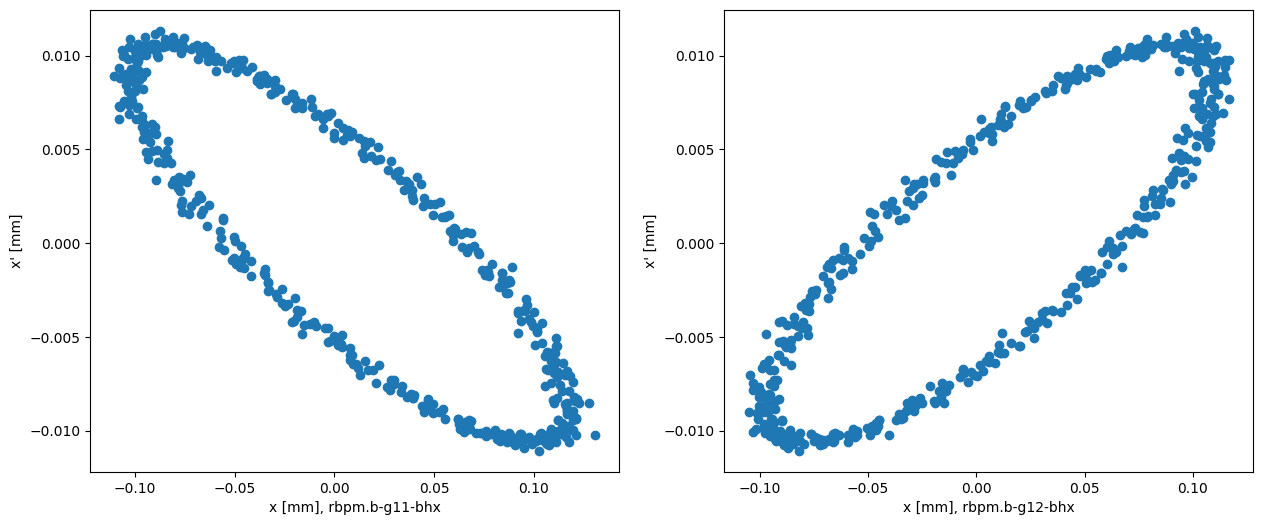

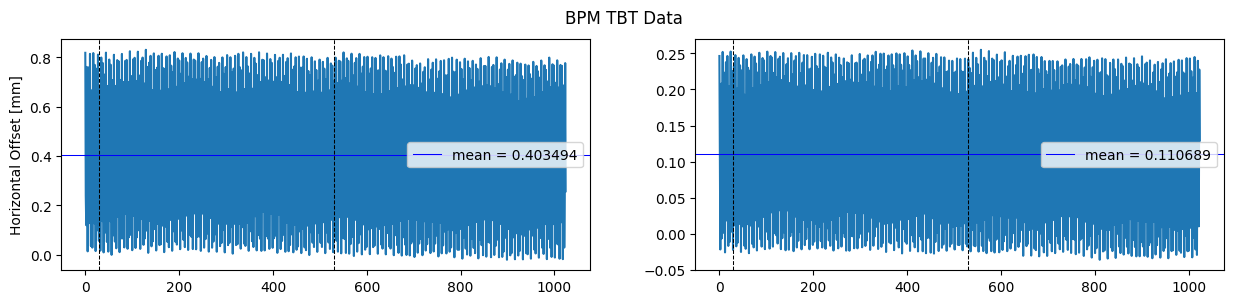

Correlation from bpm 1 & 2: 0.9978866684221059 0.9979779012820618



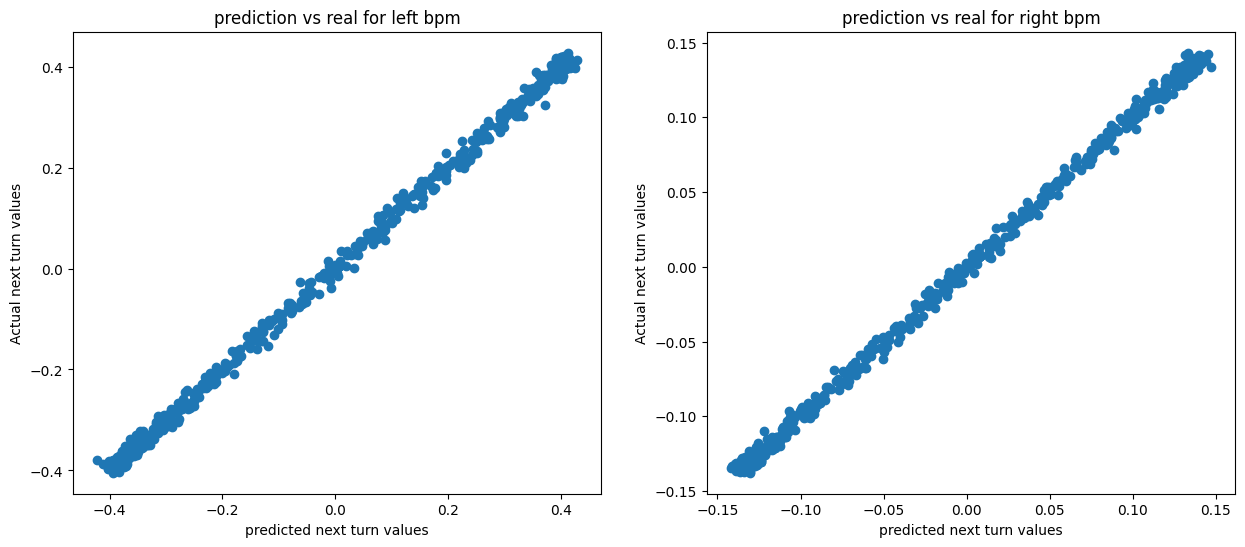


M:
[[  -4.56496628 -223.11492548]
 [   0.08659692    4.01397081]]
determinant: 0.9974230425841615
determinant after normalization: 1.0000000000000009
M after normalization:
[[  -4.57085954 -223.40296113]
 [   0.08670871    4.01915275]]
M:
[[ -1.42377746 -25.86778463]
 [  0.08659692   0.87278199]]
determinant: 0.9974230425841634
determinant after normalization: 0.9999999999999996
M after normalization:
[[ -1.42561552 -25.90117927]
 [  0.08670871   0.87390873]]
tune: 0.7055197848207173
tune: 0.7055197848207172
phix, betax, alphaxy:
4.432911545910034 232.4209591839461 4.46838055363855 4.4329115459100334 26.946719507596157 1.196174012546899
Measured Beta for left bpm: 232.4209591839461
Model Beta for left bpm: 207.4007359
Measured Beta for right bpm: 26.946719507596157
Model Beta for right bpm: 23.48110778

Measured Beta for bpm 1, 2: 232.4209591839461 26.946719507596157

beta beat at bpm 1, 2:
-0.12063709984139023 -0.14759149185235582




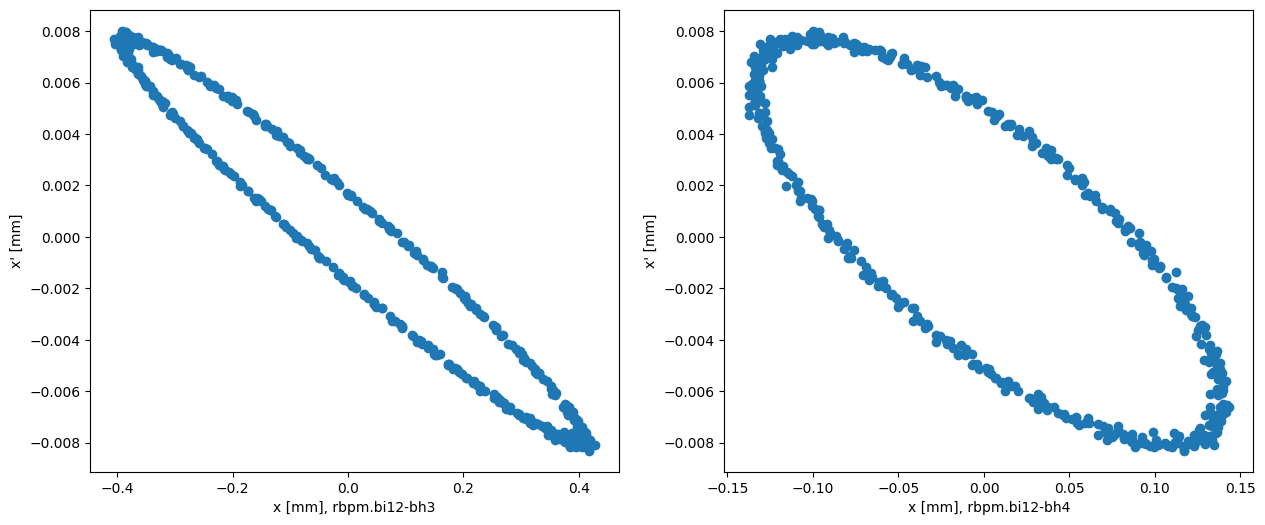

In [31]:
interval = 500
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 81, 82
Bpmsy = 81, 82
b_MADxx = [27.8045429, 72.25234952]
b_MADxy = [23.90594497, 191.9789791]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res12xb = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

#at IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 84, 85
Bpmsy = 84, 85
b_MADxx = [16.85054875, 17.60261014]
b_MADxy = [17.25703493, 16.56787087]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res12x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

#upstream of IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 87, 88
b_MADxx = [207.4007359, 23.48110778] 
Bpmsy = 87, 88
b_MADxy = [68.25613878, 24.21258626]

bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Res12xa = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
Bpmsx_names = np.append(Bpmsx_names, np.array(Bpmsx))

## Data Analysis

In [32]:
Data = np.array([Res6xb, Res6x, Res6xa, 
                 Res8xb, Res8x, Res8xa,
                 Res10xb, Res10x, Res10xa,
                 Res12xb, Res12x, Res12xa])

Corr_x_1, Corr_x_2, Det_x_1, Det_x_2, Tune_x_1, Tune_x_2, Beat_x_1, Beat_x_2 = Data.T

Bpmsx_Names = (np.array([Name_xbpms[i][5:] for i in Bpmsx_names]))[::2]
print(Bpmsx_Names)

['bi5-bh4' 'b-g5-bhx' 'b-g5-bhx' 'bo6-bh3' 'bo7-bh4' 'b-g7-bhx' 'bi8-bh3'
 'bi9-bh4' 'b-g9-bhx' 'bo10-bh3' 'bo11-bh4' 'b-g11-bhx' 'bi12-bh3'
 'bo11-bh4' 'b-g11-bhx' 'bi12-bh3']


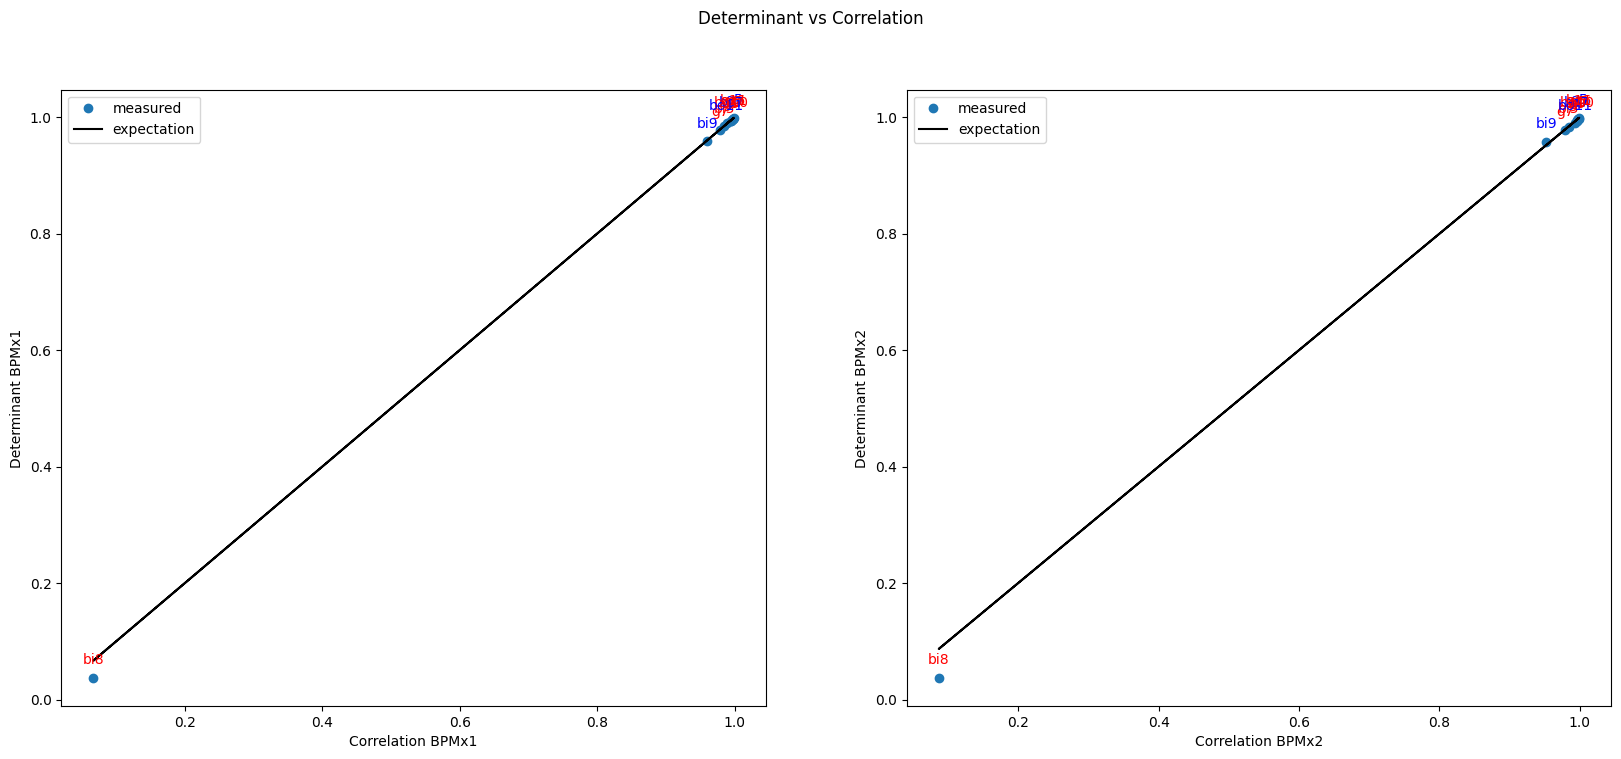

In [33]:
fig, Ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Determinant vs Correlation")
Ax[0].plot(Corr_x_1, Det_x_1, 'o', label = "measured")
Ax[0].plot(Corr_x_1, Corr_x_1, 'k', label = "expectation")
Ax[0].set_xlabel("Correlation BPMx1")
Ax[0].set_ylabel("Determinant BPMx1")


Ax[1].plot(Corr_x_2, Det_x_2, 'o', label = "measured")
Ax[1].plot(Corr_x_2, Corr_x_2, 'k', label = "expectation")
Ax[1].set_xlabel("Correlation BPMx2")
Ax[1].set_ylabel("Determinant BPMx2")

for i in range(2):
    iter = 0
    for x, y, text in zip(Data.T[i], Data.T[i + 2], Bpmsx_Names):
        iter += 1
        if 'b-' in text:
            if len(text) <= 8: text = text[2:4]
            elif len(text) > 8: text = text[2:5]
        else: 
            if len(text) <= 7:text = text[:3]
            elif len(text) > 7:text = text[:4]
        if iter % 3 - 2 == 0: color = 'b'
        else: color = 'r'
        Ax[i].annotate(text, # this is the text
            (float(x),float(y)), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center',
            color = color) # horizontal alignment can be left, right or center
        Ax[i].legend()
plt.show()

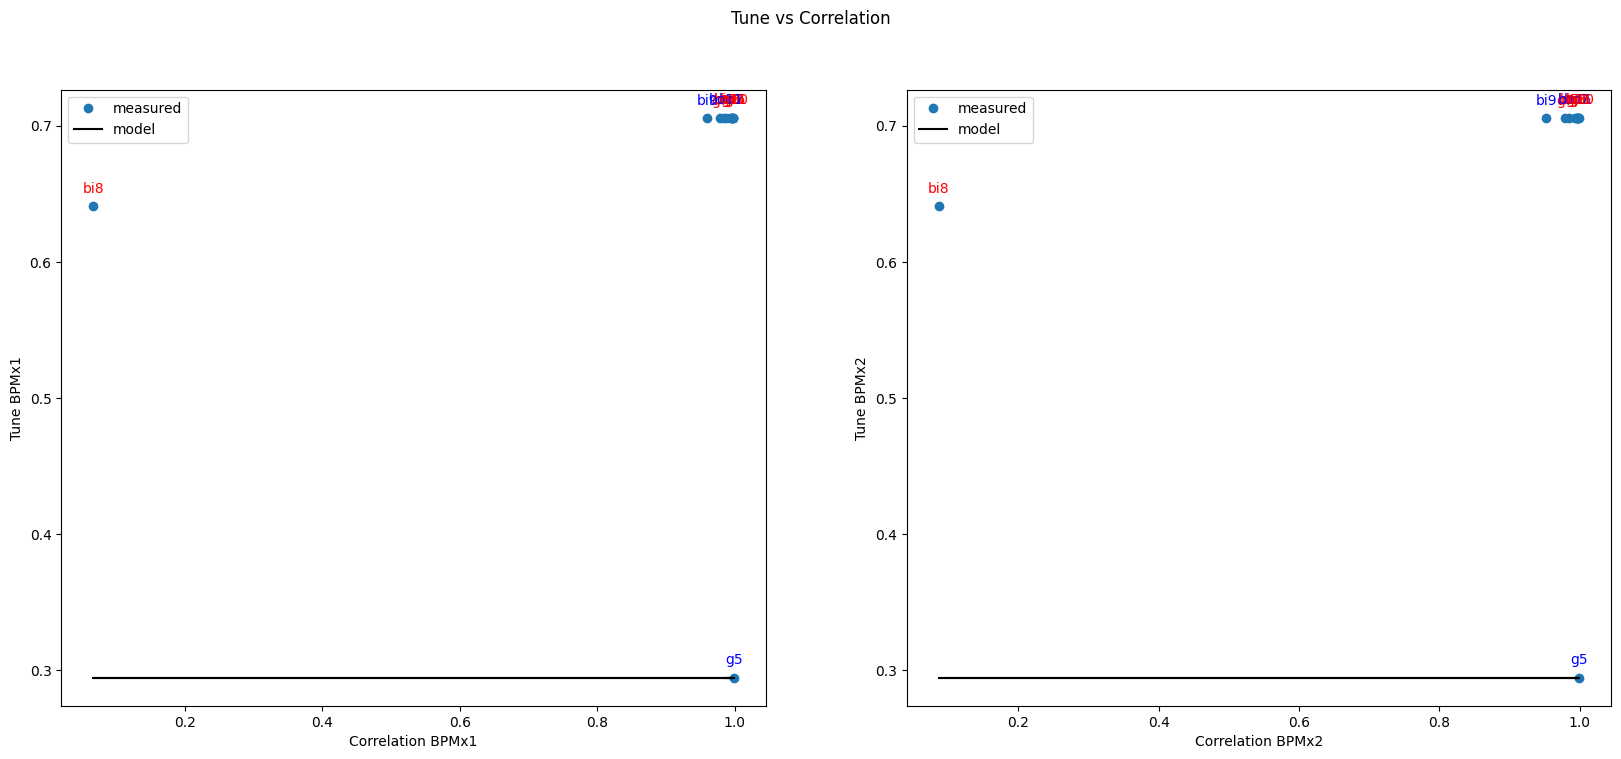

In [34]:
fig, Ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Tune vs Correlation")
Ax[0].plot(Corr_x_1, Tune_x_1, 'o', label = "measured")
Ax[0].plot(Corr_x_1, np.ones(12)*nu_x, 'k', label = "model")
Ax[0].set_xlabel("Correlation BPMx1")
Ax[0].set_ylabel("Tune BPMx1")

Ax[1].plot(Corr_x_2, Tune_x_2, 'o', label = "measured")
Ax[1].plot(Corr_x_2, np.ones(12)*nu_x, 'k', label = "model")
Ax[1].set_xlabel("Correlation BPMx2")
Ax[1].set_ylabel("Tune BPMx2")

for i in range(2):
    iter = 0
    for x, y, text in zip(Data.T[i], Data.T[i + 4], Bpmsx_Names):
        iter += 1
        if 'b-' in text:
            if len(text) <= 8: text = text[2:4]
            elif len(text) > 8: text = text[2:5]
        else: 
            if len(text) <= 7:text = text[:3]
            elif len(text) > 7:text = text[:4]
        if iter % 3 - 2 == 0: color = 'b'
        else: color = 'r'
        Ax[i].annotate(text, # this is the text
            (float(x),float(y)), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center',
            color = color) # horizontal alignment can be left, right or center
        Ax[i].legend()
plt.show()

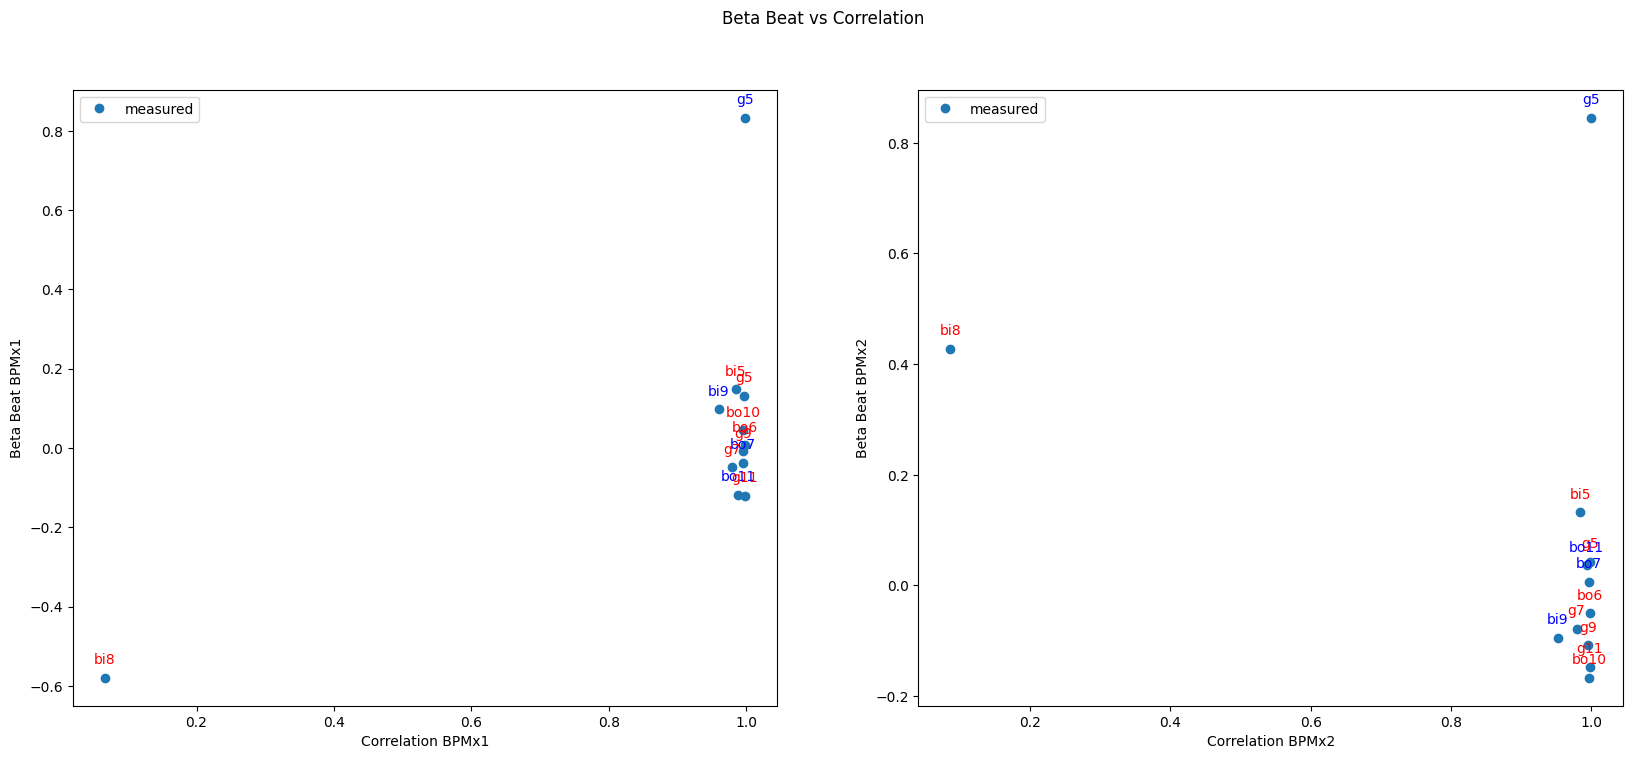

In [36]:
# Corr_x_1 = np.delete(Corr_x_1, 3)
# Corr_x_2 = np.delete(Corr_x_2, 3)
# Beat_x_1 = np.delete(Beat_x_1, 3)
# Beat_x_2 = np.delete(Beat_x_2, 3)
# Bpmsx_Names = np.delete(Bpmsx_Names, 3)

fig, Ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Beta Beat vs Correlation")
Ax[0].plot(Corr_x_1, Beat_x_1, 'o', label = "measured")
# Ax[0].plot(Corr_x_1, 1 - Corr_x_1, 'k', label = "expectation")
Ax[0].set_xlabel("Correlation BPMx1")
Ax[0].set_ylabel("Beta Beat BPMx1")

Ax[1].plot(Corr_x_2, Beat_x_2, 'o', label = "measured")
# Ax[1].plot(Corr_x_2, 1 - Corr_x_2, 'k', label = "expectation")
Ax[1].set_xlabel("Correlation BPMx2")
Ax[1].set_ylabel("Beta Beat BPMx2")

for i in range(2):
    iter = 0
    for x, y, text in zip(Data.T[i], Data.T[i + 6], Bpmsx_Names):
        iter += 1
#         if iter == 4: continue
        if 'b-' in text:
            if len(text) <= 8: text = text[2:4]
            elif len(text) > 8: text = text[2:5]
        else: 
            if len(text) <= 7:text = text[:3]
            elif len(text) > 7:text = text[:4]
        if iter % 3 - 2 == 0: color = 'b'
        else: color = 'r'
        Ax[i].annotate(text, # this is the text
            (float(x),float(y)), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center',
            color = color) # horizontal alignment can be left, right or center
        Ax[i].legend()
plt.show()

In [69]:
print(Beat_x_1)
print(Beat_x_2)

[ 0.41496269  0.82782007  0.33825103  0.18190853  0.21351205  0.38726783
 -0.51479855  0.09689843  0.05945336  0.0716815  -0.08379765 -0.00508036]
[ 0.41195914  0.84963133  0.15868796  0.16666198  0.23486018  0.39819868
  0.41864435 -0.08671241 -0.13536714 -0.11594448  0.03838911 -0.07278759]
